# LATENT-BASED IMPUTATION OF MISSING VALUES

## Description of this notebook

This notebook imputes the missing data using Latent Variable Models (LVMs).

In [ ]:
# Load all the necessary libraries

import pandas as pd
import numpy as np
from GPy import models, kern
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings("ignore")
import joblib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
import itertools
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import seaborn as sns

In [2]:
os.chdir('..') # move to the general directory

In [854]:
# Load the data
data_complete = pd.read_csv('DATA/input_DATA_NO_NAs_INPUT.csv')
data_incomplete = pd.read_csv('DATA/data.csv').drop(columns=['ADAS13'])

In [855]:
X_train, X_test = train_test_split(data_complete.values, test_size=0.3, random_state=42)
X_train = pd.DataFrame(X_train, columns=data_complete.columns)
X_test = pd.DataFrame(X_test, columns=data_complete.columns)

In [46]:
subject_details = ['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4']
fdg_pet = ['AngularLeft', 'AngularRight', 'CingulumPostBilateral', 'TemporalLeft', 'TemporalRight']
nepb = ['MMSE', 'RAVLT_learning', 'RAVLT_immediate', 'RAVLT_perc_forgetting', 'FAQ']
av_45 = ['CEREBELLUMGREYMATTER_UCBERKELEYAV45_10_17_16', 'WHOLECEREBELLUM_UCBERKELEYAV45_10_17_16', 'ERODED_SUBCORTICALWM_UCBERKELEYAV45_10_17_16', 'FRONTAL_UCBERKELEYAV45_10_17_16', 
               'CINGULATE_UCBERKELEYAV45_10_17_16', 'PARIETAL_UCBERKELEYAV45_10_17_16', 'TEMPORAL_UCBERKELEYAV45_10_17_16']
csf_values = ['ABETA_UPENNBIOMK9_04_19_17', 'TAU_UPENNBIOMK9_04_19_17', 'PTAU_UPENNBIOMK9_04_19_17']
mri = ['Hippocampus', 'WholeBrain', 'Ventricles', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']

groups = [subject_details, fdg_pet, nepb, av_45, csf_values, mri]
group_names = ['subject_details', 'fdg_pet', 'nepb', 'av_45', 'csf_values', 'mri']

## 1. GPLVM Imputation

#### Train-Test Performance Evaluation of Each Model

In [55]:
def evaluate_gplvm_models(train_data, test_data, input_dim=2, n_runs=10):
   
    overall_r2_scores = []
    # --- Entrenar imputer con datos de entrenamiento con faltantes ---
    gplvm = models.BayesianGPLVM(Y=np.array(train_data), input_dim=input_dim, init='PCA')
    gplvm.optimize() # Asumiendo que el imputer tiene método 'train'

    for _ in range(n_runs):
        
        # --- Crear datos con faltantes en test ---
        test_missing = test_data.copy()
        total_test = test_missing.size
        missing_count_test = int(total_test * 0.2)
        missing_indices_test = np.random.choice(total_test, size=missing_count_test, replace=False)
        row_idx_test, col_idx_test = np.unravel_index(missing_indices_test, test_missing.shape)
        test_missing.values[row_idx_test, col_idx_test] = np.nan

        imputed = test_data.copy()

        # --- Imputar valores faltantes en test ---
        # Debemos identificar qué filas tienen faltantes en test
        missing_mask_test = np.isnan(test_missing.values)
        rows_with_missing = np.any(missing_mask_test, axis=1)
        missing_rows_indices = np.where(rows_with_missing)[0]

        # Obtener representación latente para esas filas (dependiendo del imputer)
        X_missing = gplvm.X.mean[missing_rows_indices]  # Ajusta según imputer real
        mu_pred, var_pred = gplvm.predict(X_missing)

        filled = imputed.values.copy()
        filled[rows_with_missing] = np.where(missing_mask_test[rows_with_missing], mu_pred, filled[rows_with_missing])
        data_imputed = pd.DataFrame(filled, columns=test_data.columns)

        # --- Calcular métricas sólo para valores que estaban faltantes ---
        mask = np.zeros_like(test_missing.values, dtype=bool)
        mask[row_idx_test, col_idx_test] = True

        true_values = test_data.values[mask]
        imputed_values = data_imputed.values[mask]

        overall_r2_scores.append(r2_score(true_values, imputed_values))

    print(f"Overall R2: {np.mean(overall_r2_scores):.4f}")
    return np.mean(overall_r2_scores), gplvm


#### Overall Performance Evaluation of each Imputer on the Observed Values

(Comparison of imputed values against true values)

In [ ]:
def overall_imputation_performance_gplvm(data, imputer, n_runs=10):
    overall_r2_scores_gplvm = []

    for _ in range(n_runs):
        data_original = data.copy()
        data_missing = data_original.copy()

        total_values = data_missing.size
        missing_count = int(total_values * 0.2)

        missing_indices = np.random.choice(total_values, size=missing_count, replace=False)
        row_indices, col_indices = np.unravel_index(missing_indices, data_missing.shape)

        data_missing.values[row_indices, col_indices] = np.nan

        imputed_mean = data.copy()
        rows = data_missing.shape[0]
        imputed_mean.iloc[:rows, :] = data_missing.copy()

        missing_mask = np.isnan(imputed_mean)
        rows_with_missing = np.any(missing_mask, axis=1)
        missing_row_indices = np.where(rows_with_missing)[0]

        X_missing = imputer.X.mean[missing_row_indices]
        mu_pred, var_pred = imputer.predict(X_missing)

        filled = imputed_mean.values.copy()
        filled[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, filled[rows_with_missing])
        data_imputed = pd.DataFrame(filled, columns=data.columns)

        mask = np.zeros_like(data_missing.values, dtype=bool)
        mask[row_indices, col_indices] = True

        true_values = data_original.values[mask]
        imputed_values = data_imputed.values[mask]
        
        overall_r2_scores_gplvm.append(r2_score(true_values, imputed_values))
    print(f"Overall R2: {np.mean(overall_r2_scores_gplvm):.4f}")
    

#### Per-Group Imputation Performance

In [ ]:
def evaluate_imputation_gplvm_groups(data_complete, imputer, groups, group_names, n_runs=10):
    
    # Initialize dicts to store scores for each group across runs
    group_r2_scores_gplvm = {name: [] for name in group_names}

    for group, name in zip(groups, group_names):
        for _ in range(n_runs):
            data_original = data_complete[group].copy()
            data_missing = data_original.copy()

            # Get total number of values in the DataFrame
            total_values = data_missing.size
            missing_count = int(total_values * 0.2)

            # Randomly select indices to mask
            missing_indices = np.random.choice(total_values, size=missing_count, replace=False)
            row_indices, col_indices = np.unravel_index(missing_indices, data_missing.shape)

            # Mask values
            data_missing.values[row_indices, col_indices] = np.nan

            # Prepare imputed DataFrame for filling
            imputed = data_original.copy()
            rows = data_missing.shape[0]

            # Insert the masked data into the imputed DataFrame
            imputed.loc[:rows, group] = data_missing.copy()

            # Get column indices of group in original data
            group_indices = [data_complete.columns.get_loc(col) for col in group]

            # Identify missing mask
            missing_mask = np.isnan(imputed)
            # Rows with missing data
            rows_with_missing = np.any(missing_mask, axis=1)
            missing_row_indices = np.where(rows_with_missing)[0]

            # Predict missing values using GPLVM model
            X_missing = imputer.X.mean[missing_row_indices]
            mu_pred, var_pred = imputer.predict(X_missing)
            mu_pred_group = mu_pred[:, group_indices]

            # Fill missing values with predictions
            filled = imputed.values.copy()
            filled[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred_group, filled[rows_with_missing])
            data_imputed = pd.DataFrame(filled, columns=data_original.columns)

            # Evaluate only masked values
            mask = np.zeros_like(data_missing.values, dtype=bool)
            mask[row_indices, col_indices] = True

            true_values = data_original.values[mask]
            imputed_values = data_imputed.values[mask]

            r2 = r2_score(true_values, imputed_values)

            group_r2_scores_gplvm[name].append(r2)

    # Output average scores per group
    for name in group_names:
        print(f"Overall R2 {name}: {np.mean(group_r2_scores_gplvm[name]):.4f}")
        print('---------------------------------------------')


### Training Single GPLVM

#### 1.1 Observed Data

##### **Step 1:** Evaluate the optimal latent dimension and the best kernel

The differences between the best performers was minimum, therefore, for simplicity, the latent dimension chosen was **2** and the kernel **Matern + Linear + White**.

In [ ]:
results_gplvm_observed = []

for input_dim in range(2, 11):
    # Define kernel configurations tested
    '''kernel_options = [
        kern.RBF(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.Matern52(input_dim=1),
        kern.RBF(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.RatQuad(input_dim=input_dim),
        kern.RBF(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.Exponential(input_dim=input_dim),
        kern.RBF(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.Linear(input_dim=input_dim),
        kern.Matern52(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.RatQuad(input_dim=input_dim),
        kern.Matern52(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.Exponential(input_dim=input_dim), 
        kern.Matern52(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.Linear(input_dim=input_dim),
        kern.RatQuad(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.Exponential(input_dim=input_dim),
        kern.RatQuad(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.Linear(input_dim=input_dim),
        kern.Exponential(input_dim=input_dim) + kern.White(input_dim=input_dim) + kern.Linear(input_dim=input_dim),
        kern.RBF(input_dim=input_dim) + kern.White(input_dim=input_dim),
        kern.Matern52(input_dim=input_dim) + kern.White(input_dim=input_dim),
        kern.RatQuad(input_dim=input_dim) + kern.White(input_dim=input_dim),
        kern.White(input_dim=input_dim) + kern.Linear(input_dim=input_dim),
        kern.Exponential(input_dim=input_dim) + kern.White(input_dim=input_dim)
    ]
    for kern_set in kernel_options:'''
    model, r2 = evaluate_gplvm_models(X_train, X_test, input_dim)
    '''#results_gplvm_observed.append({
            'input_dim': input_dim,
            'kernel': kern_set,
            'r2': r2
        })'''
    print(f"Input_dim: {input_dim}, R2: {r2:.4f}")
        
results_gplvm_observed = sorted(results_gplvm_observed, key=lambda x: x['r2'], reverse=True)

Overall R2: 0.9828
Input_dim: 2, R2: 0.9828
Overall R2: 0.9832
Input_dim: 3, R2: 0.9832
Overall R2: 0.9833
Input_dim: 4, R2: 0.9833
Overall R2: 0.9806
Input_dim: 5, R2: 0.9806
Overall R2: 0.9823
Input_dim: 6, R2: 0.9823
Overall R2: 0.9831
Input_dim: 7, R2: 0.9831
Overall R2: 0.9822
Input_dim: 8, R2: 0.9822
Overall R2: 0.9827
Input_dim: 9, R2: 0.9827
Overall R2: 0.9837
Input_dim: 10, R2: 0.9837


In [24]:
# Separate the categorical and numerical variables
input_cat = X_train[['PTGENDER', 'APOE4']]
input_num = X_train.drop(columns=['PTGENDER', 'APOE4'])


# Scale the data 
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_num)
input_scaled = pd.DataFrame(input_scaled, columns=input_num.columns)

# Concatenate scaled data with categorical variables
input = pd.concat([input_scaled, input_cat], axis=1)

# Transform to numpy arrays
input = np.array(input)

In [ ]:
r2, model = evaluate_gplvm_models(input, X_test, 2)

Overall R2: -0.0691


In [21]:
#results_gplvm_observed

##### **Step 2:** Train the final model to generate the latent representation of the complete observed data

In [5]:
# Define training and testing sets for evaluation
X_train, X_test = train_test_split(data_complete.values, test_size=0.3, random_state=42)
X_train = pd.DataFrame(X_train, columns=data_complete.columns)
X_test = pd.DataFrame(X_test, columns=data_complete.columns)

r2, gplvm_observed_train = evaluate_gplvm_models(X_train, X_test, input_dim=2)

Overall R2: 0.9836


In [ ]:
# Train the model

input = np.array(data_complete)

d = 2 # latent dimension

gplvm_observed = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_observed.optimize()

In [ ]:
joblib.dump(gplvm_observed, 'FINAL MODELS/gplvm_observed.pkl')

In [12]:
latent1 = pd.DataFrame(gplvm_observed.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_observed.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})
latent3 = pd.DataFrame(gplvm_observed.X.mean[:, 2], columns=['mean']).rename(columns={'mean': 'Latent Dimension 3'})


latent_observed = pd.concat([latent1, latent2, latent3], axis=1)

In [14]:
latent_observed.to_csv('GPLVM IMPUTATION/latent_obsersed_df.csv', index=False)

#### 1.2 Pre-Imputed Mean

In [ ]:
# Training and testing on the pre-imputed dataset

mean_data = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

# Define training and testing sets for evaluation
X_train_mean, X_test_mean = train_test_split(mean_data.values, test_size=0.3, random_state=42)
X_train_mean = pd.DataFrame(X_train_mean, columns=mean_data.columns)
X_test_mean = pd.DataFrame(X_test_mean, columns=mean_data.columns)

d = 2 # latent dimension

r2_mean, gplvm_mean_train = evaluate_gplvm_models(X_train_mean, X_test_mean, input_dim=2)

Overall R2: 0.9748


##### Training

In [909]:
# Training on the complete pre-imputed dataset
mean_data = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])


d = 2

gplvm_mean = models.BayesianGPLVM(Y=np.array(mean_data), input_dim=d, init='PCA')
gplvm_mean.optimize()

##### Test: overall + per subset of features

In [ ]:
# Testing overall performance on the complete observed data

overall_imputation_performance_gplvm(data=data_complete, imputer=gplvm_mean, n_runs=10)

Overall R2: 0.9751


In [50]:
# Testing overall performance on complete subsets of features

evaluate_imputation_gplvm_groups(data_complete, gplvm_mean, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9796
---------------------------------------------
Overall R2 fdg_pet: -0.0455
---------------------------------------------
Overall R2 nepb: 0.5588
---------------------------------------------
Overall R2 av_45: 0.5716
---------------------------------------------
Overall R2 csf_values: 0.6089
---------------------------------------------
Overall R2 mri: 0.9686
---------------------------------------------


In [11]:
joblib.dump(gplvm_mean, 'FINAL MODELS/gplvm_mean.pkl')

['FINAL MODELS/gplvm_mean.pkl']

In [12]:
imputed_mean = data_incomplete.copy()

missing_mask = np.isnan(imputed_mean) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mean.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mean.predict(X_missing) # predict the missing values using the trained model
imputed_mean.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mean.values[rows_with_missing]) # fill in the missing values

In [13]:
imputed_mean.to_csv('GPLVM IMPUTATION/imputed_gplvm_mean_df.csv', index=False)

In [910]:
latent1 = pd.DataFrame(gplvm_mean.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mean.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mean = pd.concat([latent1, latent2], axis=1)
latent_mean.to_csv('GPLVM IMPUTATION/latent_mean_df.csv', index=False)

#### 1.3 Pre-Imputed Median

In [ ]:
median_data = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

# Define training and testing sets for evaluation
X_train_median, X_test_median = train_test_split(median_data.values, test_size=0.3, random_state=42)
X_train_median = pd.DataFrame(X_train_median, columns=median_data.columns)
X_test_median = pd.DataFrame(X_test_median, columns=median_data.columns)

r2_median, gplvm_median_train = evaluate_gplvm_models(X_train_median, X_test_median, input_dim=2)

Overall R2: 0.9742


##### Training

In [16]:
d = 2

gplvm_median = models.BayesianGPLVM(Y=np.array(median_data), input_dim=d, init='PCA')
gplvm_median.optimize()

##### Test: overall + per subset of features

In [ ]:
# Testing overall performance on the complete observed data

overall_imputation_performance_gplvm(data=data_complete, imputer=gplvm_median, n_runs=10)

Overall R2: 0.9741


In [ ]:
# Testing overall performance on complete subsets of features

evaluate_imputation_gplvm_groups(data_complete, gplvm_median, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9800
---------------------------------------------
Overall R2 fdg_pet: -0.0791
---------------------------------------------
Overall R2 nepb: 0.5146
---------------------------------------------
Overall R2 av_45: 0.5471
---------------------------------------------
Overall R2 csf_values: 0.5893
---------------------------------------------
Overall R2 mri: 0.9684
---------------------------------------------


In [18]:
joblib.dump(gplvm_median, 'FINAL MODELS/gplvm_median.pkl')

['FINAL MODELS/gplvm_median.pkl']

In [ ]:
imputed_median = data_incomplete.copy()

missing_mask = np.isnan(imputed_median) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_median.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_median.predict(X_missing) # predict the missing values using the trained model
imputed_median.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_median.values[rows_with_missing]) # fill in the missing values

In [ ]:
imputed_median.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_df.csv', index=False)

In [21]:
latent1 = pd.DataFrame(gplvm_median.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_median.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_median = pd.concat([latent1, latent2], axis=1)
latent_median.to_csv('GPLVM IMPUTATION/latent_median_df.csv', index=False)

#### 1.4 Pre-Imputed Mode

In [22]:
mode_data = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

# Define training and testing sets for evaluation
X_train_mode, X_test_mode = train_test_split(mode_data.values, test_size=0.3, random_state=42)
X_train_mode = pd.DataFrame(X_train_mode, columns=mode_data.columns)
X_test_mode = pd.DataFrame(X_test_mode, columns=mode_data.columns)

r2_mode, gplvm_mode_train = evaluate_gplvm_models(X_train_mode, X_test_mode, input_dim=2)

Overall R2: 0.9756


##### Training

In [23]:
d = 2

gplvm_mode = models.BayesianGPLVM(Y=np.array(mode_data), input_dim=d, init='PCA')
gplvm_mode.optimize()

##### Test: overall + per subset of features

In [ ]:
# Testing overall performance on the complete observed data

overall_imputation_performance_gplvm(data=data_complete, imputer=gplvm_mode, n_runs=10)

Overall R2: 0.9764


In [52]:
# Testing overall performance on complete subsets of features

evaluate_imputation_gplvm_groups(data_complete, gplvm_mode, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9803
---------------------------------------------
Overall R2 fdg_pet: -0.2225
---------------------------------------------
Overall R2 nepb: 0.5434
---------------------------------------------
Overall R2 av_45: 0.3933
---------------------------------------------
Overall R2 csf_values: 0.6078
---------------------------------------------
Overall R2 mri: 0.9674
---------------------------------------------


In [25]:
joblib.dump(gplvm_mode, 'FINAL MODELS/gplvm_mode.pkl')

['FINAL MODELS/gplvm_mode.pkl']

In [26]:
imputed_mode = data_incomplete.copy()

missing_mask = np.isnan(imputed_mode) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mode.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mode.predict(X_missing) # predict the missing values using the trained model
imputed_mode.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mode.values[rows_with_missing]) # fill in the missing values

In [27]:
imputed_mode.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_df.csv', index=False)

In [28]:
latent1 = pd.DataFrame(gplvm_mode.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mode.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mode = pd.concat([latent1, latent2], axis=1)
latent_mode.to_csv('GPLVM IMPUTATION/latent_mode_df.csv', index=False)

#### 1.5 Pre-Imputed KNN

In [29]:
knn_data = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

# Define training and testing sets for evaluation
X_train_knn, X_test_knn = train_test_split(knn_data.values, test_size=0.3, random_state=42)
X_train_knn = pd.DataFrame(X_train_knn, columns=knn_data.columns)
X_test_knn = pd.DataFrame(X_test_knn, columns=knn_data.columns)

r2_knn, gplvm_knn_train = evaluate_gplvm_models(X_train_knn, X_test_knn, input_dim=2)

Overall R2: 0.9750


##### Training

In [30]:
d = 2

gplvm_knn = models.BayesianGPLVM(Y=np.array(knn_data), input_dim=d, init='PCA')
gplvm_knn.optimize()

##### Test: overall + per subset of features

In [ ]:
# Testing overall performance on the complete observed data

overall_imputation_performance_gplvm(data=data_complete, imputer=gplvm_knn, n_runs=10)

Overall R2: 0.9750


In [53]:
# Testing overall performance on complete subsets of features

evaluate_imputation_gplvm_groups(data_complete, gplvm_knn, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9798
---------------------------------------------
Overall R2 fdg_pet: -0.0351
---------------------------------------------
Overall R2 nepb: 0.5267
---------------------------------------------
Overall R2 av_45: 0.5176
---------------------------------------------
Overall R2 csf_values: 0.6244
---------------------------------------------
Overall R2 mri: 0.9673
---------------------------------------------


In [32]:
joblib.dump(gplvm_knn, 'FINAL MODELS/gplvm_knn.pkl')

['FINAL MODELS/gplvm_knn.pkl']

In [33]:
imputed_knn = data_incomplete.copy()

missing_mask = np.isnan(imputed_knn) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_knn.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_knn.predict(X_missing) # predict the missing values using the trained model
imputed_knn.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_knn.values[rows_with_missing]) # fill in the missing values

In [34]:
imputed_knn.to_csv('GPLVM IMPUTATION/imputed_gplvm_knn_df.csv', index=False)

In [35]:
latent1 = pd.DataFrame(gplvm_knn.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_knn.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_knn = pd.concat([latent1, latent2], axis=1)
latent_knn.to_csv('GPLVM IMPUTATION/latent_knn_df.csv', index=False)

#### 1.6 Pre-Imputed Iterative

In [37]:
iter_data = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

# Define training and testing sets for evaluation
X_train_iter, X_test_iter = train_test_split(iter_data.values, test_size=0.3, random_state=42)
X_train_iter = pd.DataFrame(X_train_iter, columns=iter_data.columns)
X_test_iter = pd.DataFrame(X_test_iter, columns=iter_data.columns)

r2_iter, gplvm_iter_train = evaluate_gplvm_models(X_train_iter, X_test_iter, input_dim=2)

Overall R2: 0.9753


##### Training

In [38]:
d = 2

gplvm_iter = models.BayesianGPLVM(Y=np.array(iter_data), input_dim=d, init='PCA')
gplvm_iter.optimize()

##### Test: overall + per subset of features

In [ ]:
# Testing overall performance on the complete observed data

overall_imputation_performance_gplvm(data=data_complete, imputer=gplvm_iter, n_runs=10)

Overall R2: 0.9737


In [54]:
# Testing overall performance on complete subsets of features

evaluate_imputation_gplvm_groups(data_complete, gplvm_iter, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9775
---------------------------------------------
Overall R2 fdg_pet: -0.2157
---------------------------------------------
Overall R2 nepb: 0.5159
---------------------------------------------
Overall R2 av_45: 0.5366
---------------------------------------------
Overall R2 csf_values: 0.5765
---------------------------------------------
Overall R2 mri: 0.9695
---------------------------------------------


In [40]:
joblib.dump(gplvm_iter, 'FINAL MODELS/gplvm_iter.pkl')

['FINAL MODELS/gplvm_iter.pkl']

In [41]:
imputed_iter = data_incomplete.copy()

missing_mask = np.isnan(imputed_iter) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_iter.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_iter.predict(X_missing) # predict the missing values using the trained model
imputed_iter.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_iter.values[rows_with_missing]) # fill in the missing values

In [42]:
imputed_iter.to_csv('GPLVM IMPUTATION/imputed_gplvm_iter_df.csv', index=False)

In [43]:
latent1 = pd.DataFrame(gplvm_iter.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_iter.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_iter = pd.concat([latent1, latent2], axis=1)
latent_iter.to_csv('GPLVM IMPUTATION/latent_iter_df.csv', index=False)

#### 1.7 Pre-Imputed MICE

In [135]:
mice_data = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

# Define training and testing sets for evaluation
X_train_mice, X_test_mice = train_test_split(mice_data.values, test_size=0.3, random_state=42)
X_train_mice = pd.DataFrame(X_train_mice, columns=mice_data.columns)
X_test_mice = pd.DataFrame(X_test_mice, columns=mice_data.columns)

r2_mice, gplvm_mice_train = evaluate_gplvm_models(X_train_mice, X_test_mice, input_dim=2)

Overall R2: 0.9735


##### Training

In [136]:
d = 2

gplvm_mice = models.BayesianGPLVM(Y=np.array(mice_data), input_dim=d, init='PCA')
gplvm_mice.optimize()

##### Test: overall + per subset of features

In [137]:
# Testing overall performance on the complete observed data

overall_imputation_performance_gplvm(data=data_complete, imputer=gplvm_mice, n_runs=10)

Overall R2: 0.9753


In [138]:
# Testing overall performance on complete subsets of features

evaluate_imputation_gplvm_groups(data_complete, gplvm_mice, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9726
---------------------------------------------
Overall R2 fdg_pet: -0.4260
---------------------------------------------
Overall R2 nepb: 0.5045
---------------------------------------------
Overall R2 av_45: 0.4759
---------------------------------------------
Overall R2 csf_values: 0.5845
---------------------------------------------
Overall R2 mri: 0.9671
---------------------------------------------


In [139]:
joblib.dump(gplvm_mice, 'FINAL MODELS/gplvm_mice.pkl')

['FINAL MODELS/gplvm_mice.pkl']

In [140]:
imputed_mice = data_incomplete.copy()

missing_mask = np.isnan(imputed_mice) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mice.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mice.predict(X_missing) # predict the missing values using the trained model
imputed_mice.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mice.values[rows_with_missing]) # fill in the missing values

In [141]:
imputed_mice.to_csv('GPLVM IMPUTATION/imputed_gplvm_mice_df.csv', index=False)

In [143]:
latent1 = pd.DataFrame(gplvm_mice.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mice.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mice = pd.concat([latent1, latent2], axis=1)
latent_mice.to_csv('GPLVM IMPUTATION/latent_mice_df.csv', index=False)

### Training Multiple GPLVMs

In [361]:
# Load the observed data
subject_details = ['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4']
fdg_pet = ['AngularLeft', 'AngularRight', 'CingulumPostBilateral', 'TemporalLeft', 'TemporalRight']
nepb = ['MMSE', 'RAVLT_learning', 'RAVLT_immediate', 'RAVLT_perc_forgetting', 'FAQ']
av_45 = ['CEREBELLUMGREYMATTER_UCBERKELEYAV45_10_17_16', 'WHOLECEREBELLUM_UCBERKELEYAV45_10_17_16', 'ERODED_SUBCORTICALWM_UCBERKELEYAV45_10_17_16', 'FRONTAL_UCBERKELEYAV45_10_17_16', 
               'CINGULATE_UCBERKELEYAV45_10_17_16', 'PARIETAL_UCBERKELEYAV45_10_17_16', 'TEMPORAL_UCBERKELEYAV45_10_17_16']
csf_values = ['ABETA_UPENNBIOMK9_04_19_17', 'TAU_UPENNBIOMK9_04_19_17', 'PTAU_UPENNBIOMK9_04_19_17']
mri = ['Hippocampus', 'WholeBrain', 'Ventricles', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']

groups = [subject_details, fdg_pet, nepb, av_45, csf_values, mri]
group_names = ['subject_details', 'fdg_pet', 'nepb', 'av_45', 'csf_values', 'mri']

#### Pre-Imputed Mean

In [375]:
# Training and testing on the pre-imputed dataset

mean_data = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [376]:
d = 2

input = np.array(mean_data[subject_details])

gplvm_subject_details = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_subject_details.optimize()

In [377]:
overall_imputation_performance_gplvm(data=data_complete[subject_details], imputer=gplvm_subject_details, n_runs=10)

Overall R2: 0.9691


In [378]:
joblib.dump(gplvm_subject_details, 'FINAL MODELS/gplvm_subject_details.pkl')

['FINAL MODELS/gplvm_subject_details.pkl']

In [379]:
imputed_mean_subject = data_incomplete[subject_details].copy()

missing_mask = np.isnan(imputed_mean_subject) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_subject_details.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_subject_details.predict(X_missing) # predict the missing values using the trained model
imputed_mean_subject.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mean_subject.values[rows_with_missing]) # fill in the missing values

In [380]:
imputed_mean_subject.to_csv('GPLVM IMPUTATION/imputed_gplvm_mean_subject_df.csv', index=False)

In [381]:
latent1 = pd.DataFrame(gplvm_subject_details.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_subject_details.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mean_subject = pd.concat([latent1, latent2], axis=1)
latent_mean_subject.to_csv('GPLVM IMPUTATION/latent_mean_subject_df.csv', index=False)

##### FDG-PET

In [383]:
d = 2

input = np.array(mean_data[fdg_pet])

gplvm_fdgpet = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_fdgpet.optimize()

In [384]:
overall_imputation_performance_gplvm(data=data_complete[fdg_pet], imputer=gplvm_fdgpet, n_runs=10)

Overall R2: -0.5088


In [385]:
joblib.dump(gplvm_fdgpet, 'FINAL MODELS/gplvm_fdgpet.pkl')

['FINAL MODELS/gplvm_fdgpet.pkl']

In [386]:
imputed_mean_fdgpet = data_incomplete[fdg_pet].copy()

missing_mask = np.isnan(imputed_mean_fdgpet) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_fdgpet.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_fdgpet.predict(X_missing) # predict the missing values using the trained model
imputed_mean_fdgpet.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mean_fdgpet.values[rows_with_missing]) # fill in the missing values

In [387]:
imputed_mean_fdgpet.to_csv('GPLVM IMPUTATION/imputed_gplvm_mean_fdgpet_df.csv', index=False)

In [388]:
latent1 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mean_fdgpet = pd.concat([latent1, latent2], axis=1)
latent_mean_fdgpet.to_csv('GPLVM IMPUTATION/latent_mean_fdgpet_df.csv', index=False)

##### NePB

In [389]:
d = 2

input = np.array(mean_data[nepb])

gplvm_nepb = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_nepb.optimize()

In [390]:
overall_imputation_performance_gplvm(data=data_complete[nepb], imputer=gplvm_nepb, n_runs=10)

Overall R2: 0.1933


In [391]:
joblib.dump(gplvm_nepb, 'FINAL MODELS/gplvm_nepb.pkl')

['FINAL MODELS/gplvm_nepb.pkl']

In [392]:
imputed_mean_nepb = data_incomplete[nepb].copy()

missing_mask = np.isnan(imputed_mean_nepb) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_nepb.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_nepb.predict(X_missing) # predict the missing values using the trained model
imputed_mean_nepb.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mean_nepb.values[rows_with_missing]) # fill in the missing values

In [393]:
imputed_mean_nepb.to_csv('GPLVM IMPUTATION/imputed_gplvm_mean_nepb_df.csv', index=False)

In [394]:
latent1 = pd.DataFrame(gplvm_nepb.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_nepb.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mean_nepb = pd.concat([latent1, latent2], axis=1)
latent_mean_nepb.to_csv('GPLVM IMPUTATION/latent_mean_nepb_df.csv', index=False)

##### AV-45

In [395]:
d = 2

input = np.array(mean_data[av_45])

gplvm_av45 = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_av45.optimize()

In [396]:
overall_imputation_performance_gplvm(data=data_complete[av_45], imputer=gplvm_av45, n_runs=10)

Overall R2: 0.4296


In [397]:
joblib.dump(gplvm_av45, 'FINAL MODELS/gplvm_av45.pkl')

['FINAL MODELS/gplvm_av45.pkl']

In [398]:
imputed_mean_av45 = data_incomplete[av_45].copy()

missing_mask = np.isnan(imputed_mean_av45) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_av45.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_av45.predict(X_missing) # predict the missing values using the trained model
imputed_mean_av45.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mean_av45.values[rows_with_missing]) # fill in the missing values

In [399]:
imputed_mean_av45.to_csv('GPLVM IMPUTATION/imputed_gplvm_mean_av45_df.csv', index=False)

In [400]:
latent1 = pd.DataFrame(gplvm_av45.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_av45.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mean_av45 = pd.concat([latent1, latent2], axis=1)
latent_mean_av45.to_csv('GPLVM IMPUTATION/latent_mean_av45_df.csv', index=False)

##### CSF Values

In [401]:
d = 2

input = np.array(mean_data[csf_values])

gplvm_csf = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_csf.optimize()

In [402]:
overall_imputation_performance_gplvm(data=data_complete[csf_values], imputer=gplvm_csf, n_runs=10)

Overall R2: 0.3972


In [403]:
joblib.dump(gplvm_csf, 'FINAL MODELS/gplvm_csf.pkl')

['FINAL MODELS/gplvm_csf.pkl']

In [404]:
imputed_mean_csf = data_incomplete[csf_values].copy()

missing_mask = np.isnan(imputed_mean_csf) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_csf.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_csf.predict(X_missing) # predict the missing values using the trained model
imputed_mean_csf.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mean_csf.values[rows_with_missing]) # fill in the missing values

In [405]:
imputed_mean_csf.to_csv('GPLVM IMPUTATION/imputed_gplvm_mean_csf_df.csv', index=False)

In [406]:
latent1 = pd.DataFrame(gplvm_csf.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_csf.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mean_csf = pd.concat([latent1, latent2], axis=1)
latent_mean_csf.to_csv('GPLVM IMPUTATION/latent_mean_csf_df.csv', index=False)

##### MRI

In [407]:
d = 2

input = np.array(mean_data[mri])

gplvm_mri = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_mri.optimize()

In [408]:
overall_imputation_performance_gplvm(data=data_complete[mri], imputer=gplvm_mri, n_runs=10)

Overall R2: 0.9682


In [409]:
joblib.dump(gplvm_mri, 'FINAL MODELS/gplvm_mri.pkl')

['FINAL MODELS/gplvm_mri.pkl']

In [411]:
imputed_mean_mri = data_incomplete[mri].copy()

missing_mask = np.isnan(imputed_mean_mri) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mri.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mri.predict(X_missing) # predict the missing values using the trained model
imputed_mean_mri.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mean_mri.values[rows_with_missing]) # fill in the missing values

In [412]:
imputed_mean_mri.to_csv('GPLVM IMPUTATION/imputed_gplvm_mean_mri_df.csv', index=False)

In [413]:
latent1 = pd.DataFrame(gplvm_mri.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mri.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mean_mri = pd.concat([latent1, latent2], axis=1)
latent_mean_mri.to_csv('GPLVM IMPUTATION/latent_mean_mri_df.csv', index=False)

#### Pre-Imputed Median

In [421]:
# Training and testing on the pre-imputed dataset

median_data = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [422]:
d = 2

input = np.array(median_data[subject_details])

gplvm_subject_details = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_subject_details.optimize()

In [423]:
overall_imputation_performance_gplvm(data=data_complete[subject_details], imputer=gplvm_subject_details, n_runs=10)

Overall R2: 0.9675


In [424]:
joblib.dump(gplvm_subject_details, 'FINAL MODELS/gplvm_subject_details_median.pkl')

['FINAL MODELS/gplvm_subject_details_median.pkl']

In [425]:
imputed_median_subject = data_incomplete[subject_details].copy()

missing_mask = np.isnan(imputed_median_subject) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_subject_details.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_subject_details.predict(X_missing) # predict the missing values using the trained model
imputed_median_subject.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_median_subject.values[rows_with_missing]) # fill in the missing values

In [426]:
imputed_median_subject.to_csv('GPLVM IMPUTATION/imputed_gplvm_median_subject_df.csv', index=False)

In [427]:
latent1 = pd.DataFrame(gplvm_subject_details.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_subject_details.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_median_subject = pd.concat([latent1, latent2], axis=1)
latent_median_subject.to_csv('GPLVM IMPUTATION/latent_median_subject_df.csv', index=False)

##### FDG-PET

In [428]:
d = 2

input = np.array(median_data[fdg_pet])

gplvm_fdgpet = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_fdgpet.optimize()

In [429]:
overall_imputation_performance_gplvm(data=data_complete[fdg_pet], imputer=gplvm_fdgpet, n_runs=10)

Overall R2: -0.5536


In [430]:
joblib.dump(gplvm_fdgpet, 'FINAL MODELS/gplvm_fdgpet_median.pkl')

['FINAL MODELS/gplvm_fdgpet_median.pkl']

In [431]:
imputed_median_fdgpet = data_incomplete[fdg_pet].copy()

missing_mask = np.isnan(imputed_median_fdgpet) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_fdgpet.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_fdgpet.predict(X_missing) # predict the missing values using the trained model
imputed_median_fdgpet.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_median_fdgpet.values[rows_with_missing]) # fill in the missing values

In [432]:
imputed_median_fdgpet.to_csv('GPLVM IMPUTATION/imputed_gplvm_median_fdgpet_df.csv', index=False)

In [433]:
latent1 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_median_fdgpet = pd.concat([latent1, latent2], axis=1)
latent_median_fdgpet.to_csv('GPLVM IMPUTATION/latent_median_fdgpet_df.csv', index=False)

##### NePB

In [434]:
d = 2

input = np.array(median_data[nepb])

gplvm_nepb = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_nepb.optimize()

In [435]:
overall_imputation_performance_gplvm(data=data_complete[nepb], imputer=gplvm_nepb, n_runs=10)

Overall R2: 0.1620


In [436]:
joblib.dump(gplvm_nepb, 'FINAL MODELS/gplvm_nepb_median.pkl')

['FINAL MODELS/gplvm_nepb_median.pkl']

In [437]:
imputed_median_nepb = data_incomplete[nepb].copy()

missing_mask = np.isnan(imputed_median_nepb) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_nepb.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_nepb.predict(X_missing) # predict the missing values using the trained model
imputed_median_nepb.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_median_nepb.values[rows_with_missing]) # fill in the missing values

In [438]:
imputed_median_nepb.to_csv('GPLVM IMPUTATION/imputed_gplvm_median_nepb_df.csv', index=False)

In [439]:
latent1 = pd.DataFrame(gplvm_nepb.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_nepb.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_median_nepb = pd.concat([latent1, latent2], axis=1)
latent_median_nepb.to_csv('GPLVM IMPUTATION/latent_median_nepb_df.csv', index=False)

##### AV-45

In [440]:
d = 2

input = np.array(median_data[av_45])

gplvm_av45 = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_av45.optimize()

In [441]:
overall_imputation_performance_gplvm(data=data_complete[av_45], imputer=gplvm_av45, n_runs=10)

Overall R2: 0.4257


In [442]:
joblib.dump(gplvm_av45, 'FINAL MODELS/gplvm_av45_median.pkl')

['FINAL MODELS/gplvm_av45_median.pkl']

In [443]:
imputed_median_av45 = data_incomplete[av_45].copy()

missing_mask = np.isnan(imputed_median_av45) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_av45.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_av45.predict(X_missing) # predict the missing values using the trained model
imputed_median_av45.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_median_av45.values[rows_with_missing]) # fill in the missing values

In [444]:
imputed_median_av45.to_csv('GPLVM IMPUTATION/imputed_gplvm_median_av45_df.csv', index=False)

In [445]:
latent1 = pd.DataFrame(gplvm_av45.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_av45.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_median_av45 = pd.concat([latent1, latent2], axis=1)
latent_median_av45.to_csv('GPLVM IMPUTATION/latent_median_av45_df.csv', index=False)

##### CSF Values

In [446]:
d = 2

input = np.array(median_data[csf_values])

gplvm_csf = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_csf.optimize()

In [447]:
overall_imputation_performance_gplvm(data=data_complete[csf_values], imputer=gplvm_csf, n_runs=10)

Overall R2: 0.3239


In [448]:
joblib.dump(gplvm_csf, 'FINAL MODELS/gplvm_csf_median.pkl')

['FINAL MODELS/gplvm_csf_median.pkl']

In [449]:
imputed_median_csf = data_incomplete[csf_values].copy()

missing_mask = np.isnan(imputed_median_csf) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_csf.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_csf.predict(X_missing) # predict the missing values using the trained model
imputed_median_csf.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_median_csf.values[rows_with_missing]) # fill in the missing values

In [450]:
imputed_median_csf.to_csv('GPLVM IMPUTATION/imputed_gplvm_median_csf_df.csv', index=False)

In [451]:
latent1 = pd.DataFrame(gplvm_csf.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_csf.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_median_csf = pd.concat([latent1, latent2], axis=1)
latent_median_csf.to_csv('GPLVM IMPUTATION/latent_median_csf_df.csv', index=False)

##### MRI

In [452]:
d = 2

input = np.array(mean_data[mri])

gplvm_mri = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_mri.optimize()

In [453]:
overall_imputation_performance_gplvm(data=data_complete[mri], imputer=gplvm_mri, n_runs=10)

Overall R2: 0.9671


In [454]:
joblib.dump(gplvm_mri, 'FINAL MODELS/gplvm_mri_median.pkl')

['FINAL MODELS/gplvm_mri_median.pkl']

In [455]:
imputed_median_mri = data_incomplete[mri].copy()

missing_mask = np.isnan(imputed_median_mri) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mri.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mri.predict(X_missing) # predict the missing values using the trained model
imputed_median_mri.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_median_mri.values[rows_with_missing]) # fill in the missing values

In [456]:
imputed_median_mri.to_csv('GPLVM IMPUTATION/imputed_gplvm_median_mri_df.csv', index=False)

In [457]:
latent1 = pd.DataFrame(gplvm_mri.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mri.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_median_mri = pd.concat([latent1, latent2], axis=1)
latent_median_mri.to_csv('GPLVM IMPUTATION/latent_median_mri_df.csv', index=False)

#### Pre-Imputed Mode

In [466]:
# Training and testing on the pre-imputed dataset

mode_data = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [467]:
d = 2

input = np.array(mode_data[subject_details])

gplvm_subject_details = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_subject_details.optimize()

In [468]:
overall_imputation_performance_gplvm(data=data_complete[subject_details], imputer=gplvm_subject_details, n_runs=10)

Overall R2: 0.9678


In [469]:
joblib.dump(gplvm_subject_details, 'FINAL MODELS/gplvm_subject_details_mode.pkl')

['FINAL MODELS/gplvm_subject_details_mode.pkl']

In [470]:
imputed_mode_subject = data_incomplete[subject_details].copy()

missing_mask = np.isnan(imputed_mode_subject) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_subject_details.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_subject_details.predict(X_missing) # predict the missing values using the trained model
imputed_mode_subject.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mode_subject.values[rows_with_missing]) # fill in the missing values

In [471]:
imputed_mode_subject.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_subject_df.csv', index=False)

In [472]:
latent1 = pd.DataFrame(gplvm_subject_details.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_subject_details.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mode_subject = pd.concat([latent1, latent2], axis=1)
latent_mode_subject.to_csv('GPLVM IMPUTATION/latent_mode_subject_df.csv', index=False)

##### FDG-PET

In [473]:
d = 2

input = np.array(mode_data[fdg_pet])

gplvm_fdgpet = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_fdgpet.optimize()

In [474]:
overall_imputation_performance_gplvm(data=data_complete[fdg_pet], imputer=gplvm_fdgpet, n_runs=10)

Overall R2: -0.8772


In [475]:
joblib.dump(gplvm_fdgpet, 'FINAL MODELS/gplvm_fdgpet_mode.pkl')

['FINAL MODELS/gplvm_fdgpet_mode.pkl']

In [476]:
imputed_mode_fdgpet = data_incomplete[fdg_pet].copy()

missing_mask = np.isnan(imputed_mode_fdgpet) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_fdgpet.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_fdgpet.predict(X_missing) # predict the missing values using the trained model
imputed_mode_fdgpet.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mode_fdgpet.values[rows_with_missing]) # fill in the missing values

In [477]:
imputed_mode_fdgpet.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_fdgpet_df.csv', index=False)

In [478]:
latent1 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mode_fdgpet = pd.concat([latent1, latent2], axis=1)
latent_mode_fdgpet.to_csv('GPLVM IMPUTATION/latent_mode_fdgpet.csv', index=False)

##### NePB

In [479]:
d = 2

input = np.array(mode_data[nepb])

gplvm_nepb = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_nepb.optimize()

In [480]:
overall_imputation_performance_gplvm(data=data_complete[nepb], imputer=gplvm_nepb, n_runs=10)

Overall R2: 0.0938


In [481]:
joblib.dump(gplvm_nepb, 'FINAL MODELS/gplvm_nepb_mode.pkl')

['FINAL MODELS/gplvm_nepb_mode.pkl']

In [482]:
imputed_mode_nepb = data_incomplete[nepb].copy()

missing_mask = np.isnan(imputed_mode_nepb) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_nepb.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_nepb.predict(X_missing) # predict the missing values using the trained model
imputed_mode_nepb.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mode_nepb.values[rows_with_missing]) # fill in the missing values

In [483]:
imputed_mode_nepb.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_nepb_df.csv', index=False)

In [484]:
latent1 = pd.DataFrame(gplvm_nepb.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_nepb.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mode_nepb = pd.concat([latent1, latent2], axis=1)
latent_mode_nepb.to_csv('GPLVM IMPUTATION/latent_mode_nepb_df.csv', index=False)

##### AV-45

In [485]:
d = 2

input = np.array(mode_data[av_45])

gplvm_av45 = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_av45.optimize()

In [486]:
overall_imputation_performance_gplvm(data=data_complete[av_45], imputer=gplvm_av45, n_runs=10)

Overall R2: 0.1646


In [487]:
joblib.dump(gplvm_av45, 'FINAL MODELS/gplvm_av45_mode.pkl')

['FINAL MODELS/gplvm_av45_mode.pkl']

In [488]:
imputed_mode_av45 = data_incomplete[av_45].copy()

missing_mask = np.isnan(imputed_mode_av45) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_av45.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_av45.predict(X_missing) # predict the missing values using the trained model
imputed_mode_av45.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mode_av45.values[rows_with_missing]) # fill in the missing values

In [489]:
imputed_mode_av45.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_av45_df.csv', index=False)

In [490]:
latent1 = pd.DataFrame(gplvm_av45.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_av45.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mode_av45 = pd.concat([latent1, latent2], axis=1)
latent_mode_av45.to_csv('GPLVM IMPUTATION/latent_mode_av45_df.csv', index=False)

##### CSF Values

In [491]:
d = 2

input = np.array(mode_data[csf_values])

gplvm_csf = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_csf.optimize()

In [492]:
overall_imputation_performance_gplvm(data=data_complete[csf_values], imputer=gplvm_csf, n_runs=10)

Overall R2: 0.3595


In [493]:
joblib.dump(gplvm_csf, 'FINAL MODELS/gplvm_csf_mode.pkl')

['FINAL MODELS/gplvm_csf_mode.pkl']

In [494]:
imputed_mode_csf = data_incomplete[csf_values].copy()

missing_mask = np.isnan(imputed_mode_csf) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_csf.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_csf.predict(X_missing) # predict the missing values using the trained model
imputed_mode_csf.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mode_csf.values[rows_with_missing]) # fill in the missing values

In [495]:
imputed_mode_csf.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_csf_df.csv', index=False)

In [496]:
latent1 = pd.DataFrame(gplvm_csf.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_csf.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mode_csf = pd.concat([latent1, latent2], axis=1)
latent_mode_csf.to_csv('GPLVM IMPUTATION/latent_mode_csf_df.csv', index=False)

##### MRI

In [497]:
d = 2

input = np.array(mode_data[mri])

gplvm_mri = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_mri.optimize()

In [498]:
overall_imputation_performance_gplvm(data=data_complete[mri], imputer=gplvm_mri, n_runs=10)

Overall R2: 0.9665


In [499]:
joblib.dump(gplvm_mri, 'FINAL MODELS/gplvm_mri_mode.pkl')

['FINAL MODELS/gplvm_mri_mode.pkl']

In [500]:
imputed_mode_mri = data_incomplete[mri].copy()

missing_mask = np.isnan(imputed_mode_mri) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mri.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mri.predict(X_missing) # predict the missing values using the trained model
imputed_mode_mri.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mode_mri.values[rows_with_missing]) # fill in the missing values

In [501]:
imputed_mode_mri.to_csv('GPLVM IMPUTATION/imputed_gplvm_mode_mri_df.csv', index=False)

In [502]:
latent1 = pd.DataFrame(gplvm_mri.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mri.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mode_mri = pd.concat([latent1, latent2], axis=1)
latent_mode_mri.to_csv('GPLVM IMPUTATION/latent_mode_mri_df.csv', index=False)

#### Pre-Imputed KNN

In [503]:
# Training and testing on the pre-imputed dataset

data = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [504]:
d = 2

input = np.array(data[subject_details])

gplvm_subject_details = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_subject_details.optimize()

In [505]:
overall_imputation_performance_gplvm(data=data_complete[subject_details], imputer=gplvm_subject_details, n_runs=10)

Overall R2: 0.9693


In [506]:
joblib.dump(gplvm_subject_details, 'FINAL MODELS/gplvm_subject_details_knn.pkl')

['FINAL MODELS/gplvm_subject_details_knn.pkl']

In [507]:
imputed_subject = data_incomplete[subject_details].copy()

missing_mask = np.isnan(imputed_subject) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_subject_details.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_subject_details.predict(X_missing) # predict the missing values using the trained model
imputed_subject.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_subject.values[rows_with_missing]) # fill in the missing values

In [508]:
imputed_subject.to_csv('GPLVM IMPUTATION/imputed_gplvm_knn_subject_df.csv', index=False)

In [509]:
latent1 = pd.DataFrame(gplvm_subject_details.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_subject_details.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_subject = pd.concat([latent1, latent2], axis=1)
latent_subject.to_csv('GPLVM IMPUTATION/latent_knn_subject_df.csv', index=False)

##### FDG-PET

In [510]:
d = 2

input = np.array(data[fdg_pet])

gplvm_fdgpet = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_fdgpet.optimize()

In [511]:
overall_imputation_performance_gplvm(data=data_complete[fdg_pet], imputer=gplvm_fdgpet, n_runs=10)

Overall R2: -0.5951


In [512]:
joblib.dump(gplvm_fdgpet, 'FINAL MODELS/gplvm_fdgpet_knn.pkl')

['FINAL MODELS/gplvm_fdgpet_knn.pkl']

In [513]:
imputed_fdgpet = data_incomplete[fdg_pet].copy()

missing_mask = np.isnan(imputed_fdgpet) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_fdgpet.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_fdgpet.predict(X_missing) # predict the missing values using the trained model
imputed_fdgpet.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_fdgpet.values[rows_with_missing]) # fill in the missing values

In [514]:
imputed_fdgpet.to_csv('GPLVM IMPUTATION/imputed_gplvm_knn_fdgpet_df.csv', index=False)

In [515]:
latent1 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_fdgpet = pd.concat([latent1, latent2], axis=1)
latent_fdgpet.to_csv('GPLVM IMPUTATION/latent_knn_fdgpet.csv', index=False)

##### NePB

In [516]:
d = 2

input = np.array(data[nepb])

gplvm_nepb = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_nepb.optimize()

In [517]:
overall_imputation_performance_gplvm(data=data_complete[nepb], imputer=gplvm_nepb, n_runs=10)

Overall R2: 0.2075


In [518]:
joblib.dump(gplvm_nepb, 'FINAL MODELS/gplvm_nepb_knn.pkl')

['FINAL MODELS/gplvm_nepb_knn.pkl']

In [519]:
imputed_nepb = data_incomplete[nepb].copy()

missing_mask = np.isnan(imputed_nepb) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_nepb.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_nepb.predict(X_missing) # predict the missing values using the trained model
imputed_nepb.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_nepb.values[rows_with_missing]) # fill in the missing values

In [520]:
imputed_nepb.to_csv('GPLVM IMPUTATION/imputed_gplvm_knn_nepb_df.csv', index=False)

In [521]:
latent1 = pd.DataFrame(gplvm_nepb.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_nepb.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_nepb = pd.concat([latent1, latent2], axis=1)
latent_nepb.to_csv('GPLVM IMPUTATION/latent_knn_nepb_df.csv', index=False)

##### AV-45

In [522]:
d = 2

input = np.array(data[av_45])

gplvm_av45 = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_av45.optimize()

In [523]:
overall_imputation_performance_gplvm(data=data_complete[av_45], imputer=gplvm_av45, n_runs=10)

Overall R2: 0.3775


In [524]:
joblib.dump(gplvm_av45, 'FINAL MODELS/gplvm_av45_knn.pkl')

['FINAL MODELS/gplvm_av45_knn.pkl']

In [525]:
imputed_av45 = data_incomplete[av_45].copy()

missing_mask = np.isnan(imputed_av45) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_av45.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_av45.predict(X_missing) # predict the missing values using the trained model
imputed_av45.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_av45.values[rows_with_missing]) # fill in the missing values

In [526]:
imputed_av45.to_csv('GPLVM IMPUTATION/imputed_gplvm_knn_av45_df.csv', index=False)

In [527]:
latent1 = pd.DataFrame(gplvm_av45.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_av45.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_av45 = pd.concat([latent1, latent2], axis=1)
latent_av45.to_csv('GPLVM IMPUTATION/latent_knn_av45_df.csv', index=False)

##### CSF Values

In [528]:
d = 2

input = np.array(data[csf_values])

gplvm_csf = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_csf.optimize()

In [529]:
overall_imputation_performance_gplvm(data=data_complete[csf_values], imputer=gplvm_csf, n_runs=10)

Overall R2: 0.2823


In [530]:
joblib.dump(gplvm_csf, 'FINAL MODELS/gplvm_csf_knn.pkl')

['FINAL MODELS/gplvm_csf_knn.pkl']

In [531]:
imputed_csf = data_incomplete[csf_values].copy()

missing_mask = np.isnan(imputed_csf) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_csf.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_csf.predict(X_missing) # predict the missing values using the trained model
imputed_csf.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_csf.values[rows_with_missing]) # fill in the missing values

In [532]:
imputed_csf.to_csv('GPLVM IMPUTATION/imputed_gplvm_knn_csf_df.csv', index=False)

In [533]:
latent1 = pd.DataFrame(gplvm_csf.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_csf.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_csf = pd.concat([latent1, latent2], axis=1)
latent_csf.to_csv('GPLVM IMPUTATION/latent_knn_csf_df.csv', index=False)

##### MRI

In [549]:
d = 2

input = np.array(data[mri])

gplvm_mri = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_mri.optimize()

In [550]:
overall_imputation_performance_gplvm(data=data_complete[mri], imputer=gplvm_mri, n_runs=10)

Overall R2: 0.9656


In [551]:
joblib.dump(gplvm_mri, 'FINAL MODELS/gplvm_mri_knn.pkl')

['FINAL MODELS/gplvm_mri_knn.pkl']

In [552]:
imputed_mri = data_incomplete[mri].copy()

missing_mask = np.isnan(imputed_mri) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mri.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mri.predict(X_missing) # predict the missing values using the trained model
imputed_mri.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mri.values[rows_with_missing]) # fill in the missing values

In [553]:
imputed_mri.to_csv('GPLVM IMPUTATION/imputed_gplvm_knn_mri_df.csv', index=False)

In [554]:
latent1 = pd.DataFrame(gplvm_mri.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mri.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mri = pd.concat([latent1, latent2], axis=1)
latent_mri.to_csv('GPLVM IMPUTATION/latent_knn_mri_df.csv', index=False)

#### Pre-Imputed Iterative

In [555]:
# Training and testing on the pre-imputed dataset

data = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [556]:
d = 2

input = np.array(data[subject_details])

gplvm_subject_details = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_subject_details.optimize()

In [557]:
overall_imputation_performance_gplvm(data=data_complete[subject_details], imputer=gplvm_subject_details, n_runs=10)

Overall R2: 0.9664


In [558]:
joblib.dump(gplvm_subject_details, 'FINAL MODELS/gplvm_subject_details_iter.pkl')

['FINAL MODELS/gplvm_subject_details_iter.pkl']

In [559]:
imputed_subject = data_incomplete[subject_details].copy()

missing_mask = np.isnan(imputed_subject) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_subject_details.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_subject_details.predict(X_missing) # predict the missing values using the trained model
imputed_subject.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_subject.values[rows_with_missing]) # fill in the missing values

In [560]:
imputed_subject.to_csv('GPLVM IMPUTATION/imputed_gplvm_iter_subject_df.csv', index=False)

In [561]:
latent1 = pd.DataFrame(gplvm_subject_details.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_subject_details.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_subject = pd.concat([latent1, latent2], axis=1)
latent_subject.to_csv('GPLVM IMPUTATION/latent_iter_subject_df.csv', index=False)

##### FDG-PET

In [562]:
d = 2

input = np.array(data[fdg_pet])

gplvm_fdgpet = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_fdgpet.optimize()

In [563]:
overall_imputation_performance_gplvm(data=data_complete[fdg_pet], imputer=gplvm_fdgpet, n_runs=10)

Overall R2: -0.6188


In [564]:
joblib.dump(gplvm_fdgpet, 'FINAL MODELS/gplvm_fdgpet_iter.pkl')

['FINAL MODELS/gplvm_fdgpet_iter.pkl']

In [565]:
imputed_fdgpet = data_incomplete[fdg_pet].copy()

missing_mask = np.isnan(imputed_fdgpet) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_fdgpet.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_fdgpet.predict(X_missing) # predict the missing values using the trained model
imputed_fdgpet.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_fdgpet.values[rows_with_missing]) # fill in the missing values

In [566]:
imputed_fdgpet.to_csv('GPLVM IMPUTATION/imputed_gplvm_iter_fdgpet_df.csv', index=False)

In [567]:
latent1 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_fdgpet = pd.concat([latent1, latent2], axis=1)
latent_fdgpet.to_csv('GPLVM IMPUTATION/latent_iter_fdgpet.csv', index=False)

##### NePB

In [568]:
d = 2

input = np.array(data[nepb])

gplvm_nepb = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_nepb.optimize()

In [569]:
overall_imputation_performance_gplvm(data=data_complete[nepb], imputer=gplvm_nepb, n_runs=10)

Overall R2: 0.1751


In [570]:
joblib.dump(gplvm_nepb, 'FINAL MODELS/gplvm_nepb_iter.pkl')

['FINAL MODELS/gplvm_nepb_iter.pkl']

In [571]:
imputed_nepb = data_incomplete[nepb].copy()

missing_mask = np.isnan(imputed_nepb) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_nepb.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_nepb.predict(X_missing) # predict the missing values using the trained model
imputed_nepb.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_nepb.values[rows_with_missing]) # fill in the missing values

In [572]:
imputed_nepb.to_csv('GPLVM IMPUTATION/imputed_gplvm_iter_nepb_df.csv', index=False)

In [573]:
latent1 = pd.DataFrame(gplvm_nepb.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_nepb.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_nepb = pd.concat([latent1, latent2], axis=1)
latent_nepb.to_csv('GPLVM IMPUTATION/latent_iter_nepb_df.csv', index=False)

##### AV-45

In [574]:
d = 2

input = np.array(data[av_45])

gplvm_av45 = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_av45.optimize()

In [575]:
overall_imputation_performance_gplvm(data=data_complete[av_45], imputer=gplvm_av45, n_runs=10)

Overall R2: 0.4065


In [576]:
joblib.dump(gplvm_av45, 'FINAL MODELS/gplvm_av45_iter.pkl')

['FINAL MODELS/gplvm_av45_iter.pkl']

In [577]:
imputed_av45 = data_incomplete[av_45].copy()

missing_mask = np.isnan(imputed_av45) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_av45.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_av45.predict(X_missing) # predict the missing values using the trained model
imputed_av45.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_av45.values[rows_with_missing]) # fill in the missing values

In [578]:
imputed_av45.to_csv('GPLVM IMPUTATION/imputed_gplvm_iter_av45_df.csv', index=False)

In [579]:
latent1 = pd.DataFrame(gplvm_av45.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_av45.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_av45 = pd.concat([latent1, latent2], axis=1)
latent_av45.to_csv('GPLVM IMPUTATION/latent_iter_av45_df.csv', index=False)

##### CSF Values

In [580]:
d = 2

input = np.array(data[csf_values])

gplvm_csf = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_csf.optimize()

In [581]:
overall_imputation_performance_gplvm(data=data_complete[csf_values], imputer=gplvm_csf, n_runs=10)

Overall R2: 0.2945


In [582]:
joblib.dump(gplvm_csf, 'FINAL MODELS/gplvm_csf_iter.pkl')

['FINAL MODELS/gplvm_csf_iter.pkl']

In [583]:
imputed_csf = data_incomplete[csf_values].copy()

missing_mask = np.isnan(imputed_csf) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_csf.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_csf.predict(X_missing) # predict the missing values using the trained model
imputed_csf.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_csf.values[rows_with_missing]) # fill in the missing values

In [584]:
imputed_csf.to_csv('GPLVM IMPUTATION/imputed_gplvm_iter_csf_df.csv', index=False)

In [585]:
latent1 = pd.DataFrame(gplvm_csf.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_csf.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_csf = pd.concat([latent1, latent2], axis=1)
latent_csf.to_csv('GPLVM IMPUTATION/latent_iter_csf_df.csv', index=False)

##### MRI

In [586]:
d = 2

input = np.array(data[mri])

gplvm_mri = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_mri.optimize()

In [587]:
overall_imputation_performance_gplvm(data=data_complete[mri], imputer=gplvm_mri, n_runs=10)

Overall R2: 0.9668


In [588]:
joblib.dump(gplvm_mri, 'FINAL MODELS/gplvm_mri_iter.pkl')

['FINAL MODELS/gplvm_mri_iter.pkl']

In [589]:
imputed_mri = data_incomplete[mri].copy()

missing_mask = np.isnan(imputed_mri) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mri.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mri.predict(X_missing) # predict the missing values using the trained model
imputed_mri.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mri.values[rows_with_missing]) # fill in the missing values

In [590]:
imputed_mri.to_csv('GPLVM IMPUTATION/imputed_gplvm_iter_mri_df.csv', index=False)

In [591]:
latent1 = pd.DataFrame(gplvm_mri.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mri.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mri = pd.concat([latent1, latent2], axis=1)
latent_mri.to_csv('GPLVM IMPUTATION/latent_iter_mri_df.csv', index=False)

#### Pre-Imputed MICE

In [592]:
# Training and testing on the pre-imputed dataset

data = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [593]:
d = 2

input = np.array(data[subject_details])

gplvm_subject_details = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_subject_details.optimize()

In [594]:
overall_imputation_performance_gplvm(data=data_complete[subject_details], imputer=gplvm_subject_details, n_runs=10)

Overall R2: 0.9695


In [595]:
joblib.dump(gplvm_subject_details, 'FINAL MODELS/gplvm_subject_details_mice.pkl')

['FINAL MODELS/gplvm_subject_details_mice.pkl']

In [596]:
imputed_subject = data_incomplete[subject_details].copy()

missing_mask = np.isnan(imputed_subject) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_subject_details.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_subject_details.predict(X_missing) # predict the missing values using the trained model
imputed_subject.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_subject.values[rows_with_missing]) # fill in the missing values

In [597]:
imputed_subject.to_csv('GPLVM IMPUTATION/imputed_gplvm_mice_subject_df.csv', index=False)

In [598]:
latent1 = pd.DataFrame(gplvm_subject_details.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_subject_details.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_subject = pd.concat([latent1, latent2], axis=1)
latent_subject.to_csv('GPLVM IMPUTATION/latent_mice_subject_df.csv', index=False)

##### FDG-PET

In [599]:
d = 2

input = np.array(data[fdg_pet])

gplvm_fdgpet = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_fdgpet.optimize()

In [600]:
overall_imputation_performance_gplvm(data=data_complete[fdg_pet], imputer=gplvm_fdgpet, n_runs=10)

Overall R2: -0.5728


In [601]:
joblib.dump(gplvm_fdgpet, 'FINAL MODELS/gplvm_fdgpet_mice.pkl')

['FINAL MODELS/gplvm_fdgpet_mice.pkl']

In [602]:
imputed_fdgpet = data_incomplete[fdg_pet].copy()

missing_mask = np.isnan(imputed_fdgpet) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_fdgpet.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_fdgpet.predict(X_missing) # predict the missing values using the trained model
imputed_fdgpet.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_fdgpet.values[rows_with_missing]) # fill in the missing values

In [603]:
imputed_fdgpet.to_csv('GPLVM IMPUTATION/imputed_gplvm_mice_fdgpet_df.csv', index=False)

In [604]:
latent1 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_fdgpet.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_fdgpet = pd.concat([latent1, latent2], axis=1)
latent_fdgpet.to_csv('GPLVM IMPUTATION/latent_mice_fdgpet.csv', index=False)

##### NePB

In [605]:
d = 2

input = np.array(data[nepb])

gplvm_nepb = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_nepb.optimize()

In [606]:
overall_imputation_performance_gplvm(data=data_complete[nepb], imputer=gplvm_nepb, n_runs=10)

Overall R2: 0.1650


In [607]:
joblib.dump(gplvm_nepb, 'FINAL MODELS/gplvm_nepb_mice.pkl')

['FINAL MODELS/gplvm_nepb_mice.pkl']

In [608]:
imputed_nepb = data_incomplete[nepb].copy()

missing_mask = np.isnan(imputed_nepb) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_nepb.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_nepb.predict(X_missing) # predict the missing values using the trained model
imputed_nepb.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_nepb.values[rows_with_missing]) # fill in the missing values

In [609]:
imputed_nepb.to_csv('GPLVM IMPUTATION/imputed_gplvm_mice_nepb_df.csv', index=False)

In [610]:
latent1 = pd.DataFrame(gplvm_nepb.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_nepb.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_nepb = pd.concat([latent1, latent2], axis=1)
latent_nepb.to_csv('GPLVM IMPUTATION/latent_mice_nepb_df.csv', index=False)

##### AV-45

In [611]:
d = 2

input = np.array(data[av_45])

gplvm_av45 = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_av45.optimize()

In [612]:
overall_imputation_performance_gplvm(data=data_complete[av_45], imputer=gplvm_av45, n_runs=10)

Overall R2: 0.4403


In [613]:
joblib.dump(gplvm_av45, 'FINAL MODELS/gplvm_av45_mice.pkl')

['FINAL MODELS/gplvm_av45_mice.pkl']

In [614]:
imputed_av45 = data_incomplete[av_45].copy()

missing_mask = np.isnan(imputed_av45) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_av45.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_av45.predict(X_missing) # predict the missing values using the trained model
imputed_av45.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_av45.values[rows_with_missing]) # fill in the missing values

In [615]:
imputed_av45.to_csv('GPLVM IMPUTATION/imputed_gplvm_mice_av45_df.csv', index=False)

In [616]:
latent1 = pd.DataFrame(gplvm_av45.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_av45.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_av45 = pd.concat([latent1, latent2], axis=1)
latent_av45.to_csv('GPLVM IMPUTATION/latent_mice_av45_df.csv', index=False)

##### CSF Values

In [617]:
d = 2

input = np.array(data[csf_values])

gplvm_csf = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_csf.optimize()

In [618]:
overall_imputation_performance_gplvm(data=data_complete[csf_values], imputer=gplvm_csf, n_runs=10)

Overall R2: 0.3370


In [619]:
joblib.dump(gplvm_csf, 'FINAL MODELS/gplvm_csf_mice.pkl')

['FINAL MODELS/gplvm_csf_mice.pkl']

In [620]:
imputed_csf = data_incomplete[csf_values].copy()

missing_mask = np.isnan(imputed_csf) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_csf.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_csf.predict(X_missing) # predict the missing values using the trained model
imputed_csf.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_csf.values[rows_with_missing]) # fill in the missing values

In [621]:
imputed_csf.to_csv('GPLVM IMPUTATION/imputed_gplvm_mice_csf_df.csv', index=False)

In [622]:
latent1 = pd.DataFrame(gplvm_csf.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_csf.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_csf = pd.concat([latent1, latent2], axis=1)
latent_csf.to_csv('GPLVM IMPUTATION/latent_mice_csf_df.csv', index=False)

##### MRI

In [623]:
d = 2

input = np.array(data[mri])

gplvm_mri = models.BayesianGPLVM(Y=input, input_dim=d, init='PCA')
gplvm_mri.optimize()

In [624]:
overall_imputation_performance_gplvm(data=data_complete[mri], imputer=gplvm_mri, n_runs=10)

Overall R2: 0.9664


In [625]:
joblib.dump(gplvm_mri, 'FINAL MODELS/gplvm_mri_mice.pkl')

['FINAL MODELS/gplvm_mri_mice.pkl']

In [626]:
imputed_mri = data_incomplete[mri].copy()

missing_mask = np.isnan(imputed_mri) # mask the missing values, this is a dataframe with True/False depending whether the value is missing or not
rows_with_missing = np.any(missing_mask, axis=1) # identify those rows that have at least one missing value
X_missing = gplvm_mri.X.mean[rows_with_missing] # infer the latent variables for each missing row
mu_pred, var_pred = gplvm_mri.predict(X_missing) # predict the missing values using the trained model
imputed_mri.values[rows_with_missing] = np.where(missing_mask[rows_with_missing], mu_pred, imputed_mri.values[rows_with_missing]) # fill in the missing values

In [627]:
imputed_mri.to_csv('GPLVM IMPUTATION/imputed_gplvm_mice_mri_df.csv', index=False)

In [628]:
latent1 = pd.DataFrame(gplvm_mri.X.mean[:, 0], columns=['mean']).rename(columns={'mean': 'Latent Dimension 1'})
latent2 = pd.DataFrame(gplvm_mri.X.mean[:, 1], columns=['mean']).rename(columns={'mean': 'Latent Dimension 2'})

latent_mri = pd.concat([latent1, latent2], axis=1)
latent_mri.to_csv('GPLVM IMPUTATION/latent_mice_mri_df.csv', index=False)

## 2. PCA Imputation

#### Function to impute missing data

In [ ]:
def impute_missing_values_pca(data_incomplete, model, data_projected):

    columns = data_incomplete.columns

    missing_mask = np.isnan(data_incomplete.values)  # Mask to identify missing values
    rows_with_missing = np.any(missing_mask, axis=1)  # Identify rows with missing values

    # Reconstruct the data from the transformed latent space
    data_reconstructed = model.inverse_transform(data_projected)

    # Step 5: Impute missing values by averaging the reconstructed values
    # Get the predicted values for the rows with missing data
    for i in range(data_incomplete.shape[0]):
        if rows_with_missing[i]:  # If the row has missing values
            data_incomplete.values[i] = np.where(missing_mask[i], data_reconstructed[i], data_incomplete.values[i]) # fill in the missing values

    return pd.DataFrame(data_incomplete, columns=columns)

#### Evaluating overall performance of trained PCA model using observed data

In [629]:
def evaluate_imputation_pca(data_complete, model, data_projected, n_runs=10):

    overall_r2_scores_pca = []

    for _ in range(n_runs):
        data_original = data_complete.copy()
        data_missing = data_original.copy()

        # Randomly mask 20% of values
        total_values = data_missing.size
        missing_count = int(total_values * 0.2)
        missing_indices = np.random.choice(total_values, size=missing_count, replace=False)
        row_indices, col_indices = np.unravel_index(missing_indices, data_missing.shape)
        data_missing.values[row_indices, col_indices] = np.nan

        # PCA-based imputation
        imputed = data_missing.copy()
        missing_mask = np.isnan(imputed.values)
        rows_with_missing = np.any(missing_mask, axis=1)

        data_reconstructed = model.inverse_transform(data_projected)

        for i in range(imputed.shape[0]):
            if rows_with_missing[i]:
                imputed.values[i] = np.where(missing_mask[i], data_reconstructed[i], imputed.values[i])

        data_imputed = pd.DataFrame(imputed, columns=data_complete.columns)

        # Evaluate on masked entries
        mask = np.zeros_like(data_missing.values, dtype=bool)
        mask[row_indices, col_indices] = True

        true_values = data_original.values[mask]
        imputed_values = data_imputed.values[mask]

    
        overall_r2_scores_pca.append(r2_score(true_values, imputed_values))
    

    print(f"Overall R2: {np.mean(overall_r2_scores_pca):.4f}")
    

#### Evaluating Per-Group Imputation Performance

In [84]:
def evaluate_imputation_pca_groups(data_complete, model, data_projected, groups, group_names, n_runs=10):
    
    group_r2_scores_pca = {name: [] for name in group_names}

    for group, name in zip(groups, group_names):
        
        for _ in range(n_runs):
            data_original = data_complete[group].copy()
            data_missing = data_original.copy()

            # Randomly mask 20% of the data
            total_values = data_missing.size
            missing_count = int(total_values * 0.2)
            missing_indices = np.random.choice(total_values, size=missing_count, replace=False)
            row_indices, col_indices = np.unravel_index(missing_indices, data_missing.shape)
            data_missing.values[row_indices, col_indices] = np.nan

            imputed = data_original.copy()
            imputed.loc[:, :] = data_missing.copy()

            group_indices = [data_complete.columns.get_loc(col) for col in group]
     
            missing_mask = np.isnan(imputed.values)
            rows_with_missing = np.any(missing_mask, axis=1)

            # Apply PCA imputation using external train_data
            data_reconstructed = model.inverse_transform(data_projected)
            data_reconstructed_group = data_reconstructed[:, group_indices]

            # Fill missing values with reconstructed values
            for i in range(imputed.shape[0]):
                if rows_with_missing[i]:
                    imputed.values[i] = np.where(missing_mask[i], data_reconstructed_group[i], imputed.values[i])

            data_imputed = pd.DataFrame(imputed, columns=data_original.columns)

            # Evaluate only masked values
            mask = np.zeros_like(data_missing.values, dtype=bool)
            mask[row_indices, col_indices] = True

            true_values = data_original.values[mask]
            imputed_values = data_imputed.values[mask]

            r2 = r2_score(true_values, imputed_values)

            group_r2_scores_pca[name].append(r2)

    # Output average scores per group
    for name in group_names:
        print(f"Overall R2 {name}: {np.mean(group_r2_scores_pca[name]):.4f}")
        print('---------------------------------------------')

#### Principal Components

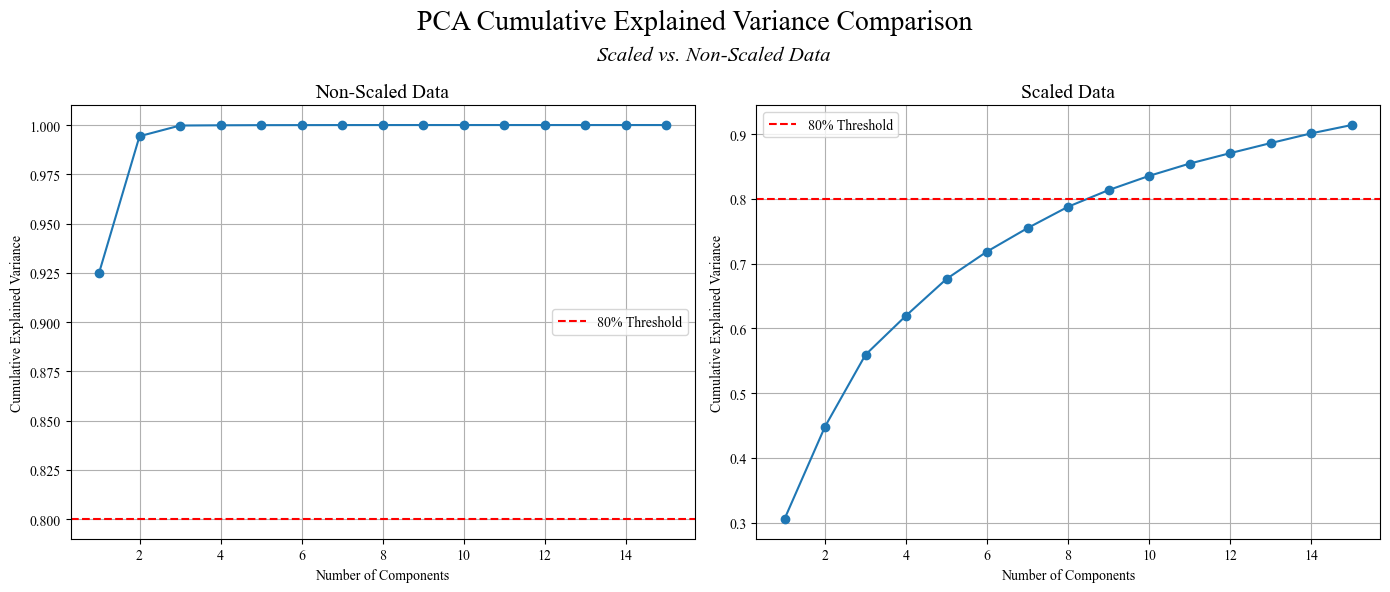

In [63]:
plt.rcParams['font.family'] = 'Times New Roman'  # Set global font

# Prepare data: separate numeric & categorical (adjust columns as needed)
X_num = X_train.drop(columns=['APOE4', 'PTGENDER'])  # numeric features only
X_cat = X_train[['APOE4', 'PTGENDER']]  # categorical (not used in PCA)

# Raw data matrix for PCA
X_raw = X_train.values

# Scaled data matrix for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
X_scaled = pd.concat([X_scaled, X_cat], axis=1).values


# Function to compute explained variance for n_components=1..15
def compute_explained_variance(X):
    variances = []
    for i in range(1, 16):
        pca = PCA(n_components=i)
        pca.fit(X)
        variances.append(np.sum(pca.explained_variance_ratio_))
    return variances

explained_raw = compute_explained_variance(X_raw)
explained_scaled = compute_explained_variance(X_scaled)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: raw data
axes[0].plot(range(1, 16), explained_raw, marker='o', linestyle='-')
axes[0].axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
axes[0].set_title('Non-Scaled Data', fontsize=14)
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].grid(True)
axes[0].legend()

# Right: scaled data
axes[1].plot(range(1, 16), explained_scaled, marker='o', linestyle='-')
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
axes[1].set_title('Scaled Data', fontsize=14)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].grid(True)
axes[1].legend()

fig.suptitle('PCA Cumulative Explained Variance Comparison', fontsize=20)
fig.text(0.43, 0.895, 'Scaled vs. Non-Scaled Data', fontsize=15, style='italic')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for suptitle
plt.show()

#### Testing Scaling Data

In [64]:
# Separate the categorical and numerical variables
input_cat = X_train[['PTGENDER', 'APOE4']]
input_num = X_train.drop(columns=['PTGENDER', 'APOE4'])


# Scale the data 
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_num)
input_scaled = pd.DataFrame(input_scaled, columns=input_num.columns)

# Concatenate scaled data with categorical variables
input = pd.concat([input_scaled, input_cat], axis=1)

# Transform to numpy arrays
input = np.array(input)

In [67]:
pca = PCA(n_components=9)
X_pca = pca.fit_transform(input)

evaluate_imputation_pca(X_test, pca, X_pca, n_runs=10)

Overall R2: -0.0709


### Training Single PCA

#### 2.1 Pre-Imputed Mean

In [85]:
# Step 1: Load data

mean_df = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(mean_df)

##### Training

In [86]:
n = 2

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [87]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mean_df.csv', index=False)

##### Test: overall + per subset of features

In [88]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete, pca, X_pca, n_runs=10)

Overall R2: 0.9755


In [89]:
# Test the overall performance on the subset of features

evaluate_imputation_pca_groups(data_complete, pca, X_pca, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9799
---------------------------------------------
Overall R2 fdg_pet: 0.0048
---------------------------------------------
Overall R2 nepb: 0.5476
---------------------------------------------
Overall R2 av_45: 0.5691
---------------------------------------------
Overall R2 csf_values: 0.6062
---------------------------------------------
Overall R2 mri: 0.9661
---------------------------------------------


In [90]:
joblib.dump(pca, 'FINAL MODELS/pca_mean.pkl')

['FINAL MODELS/pca_mean.pkl']

In [91]:
pca_mean_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [92]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mean_df.csv', index=False)

#### 2.2 Pre-Imputed Median

In [95]:
# Step 1: Load data

median_df = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(median_df)

##### Training

In [96]:
n = 2

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [97]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_median_df.csv', index=False)

##### Test: overall + per subset of features

In [98]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete, pca, X_pca, n_runs=10)

Overall R2: 0.9748


In [99]:
# Test the overall performance on the subset of features

evaluate_imputation_pca_groups(data_complete, pca, X_pca, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9793
---------------------------------------------
Overall R2 fdg_pet: 0.0034
---------------------------------------------
Overall R2 nepb: 0.5583
---------------------------------------------
Overall R2 av_45: 0.5684
---------------------------------------------
Overall R2 csf_values: 0.5718
---------------------------------------------
Overall R2 mri: 0.9660
---------------------------------------------


In [100]:
joblib.dump(pca, 'FINAL MODELS/pca_median.pkl')

['FINAL MODELS/pca_median.pkl']

In [101]:
pca_median_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [102]:
pca_median_complete.to_csv('PCA IMPUTATION/imputed_pca_median_df.csv', index=False)

#### 2.3 Pre-Imputed Mode

In [103]:
# Step 1: Load data

mode_df = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(mode_df)

##### Training

In [104]:
n = 2

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [105]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mode_df.csv', index=False)

##### Test: overall + per subset of features

In [106]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete, pca, X_pca, n_runs=10)

Overall R2: 0.9748


In [107]:
# Test the overall performance on the subset of features

evaluate_imputation_pca_groups(data_complete, pca, X_pca, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9795
---------------------------------------------
Overall R2 fdg_pet: -0.1541
---------------------------------------------
Overall R2 nepb: 0.5432
---------------------------------------------
Overall R2 av_45: 0.4221
---------------------------------------------
Overall R2 csf_values: 0.6143
---------------------------------------------
Overall R2 mri: 0.9662
---------------------------------------------


In [108]:
joblib.dump(pca, 'FINAL MODELS/pca_mode.pkl')

['FINAL MODELS/pca_mode.pkl']

In [109]:
pca_mode_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [110]:
pca_mode_complete.to_csv('PCA IMPUTATION/imputed_pca_mode_df.csv', index=False)

#### 2.4 Pre-Imputed KNN

In [111]:
# Step 1: Load data

knn_df = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(knn_df)

##### Training

In [112]:
n = 2

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [113]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_knn_df.csv', index=False)

##### Test: overall + per subset of features

In [114]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete, pca, X_pca, n_runs=10)

Overall R2: 0.9751


In [115]:
# Test the overall performance on the subset of features

evaluate_imputation_pca_groups(data_complete, pca, X_pca, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9782
---------------------------------------------
Overall R2 fdg_pet: 0.0435
---------------------------------------------
Overall R2 nepb: 0.5546
---------------------------------------------
Overall R2 av_45: 0.5477
---------------------------------------------
Overall R2 csf_values: 0.6298
---------------------------------------------
Overall R2 mri: 0.9660
---------------------------------------------


In [116]:
joblib.dump(pca, 'FINAL MODELS/pca_knn.pkl')

['FINAL MODELS/pca_knn.pkl']

In [117]:
pca_knn_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [118]:
pca_knn_complete.to_csv('PCA IMPUTATION/imputed_pca_knn_df.csv', index=False)

#### 2.5 Pre-Imputed Iterative

In [119]:
# Step 1: Load data

iter_df = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(iter_df)

##### Training

In [120]:
n = 2

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [121]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_iter_df.csv', index=False)

##### Test: overall + per subset of features

In [122]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete, pca, X_pca, n_runs=10)

Overall R2: 0.9745


In [123]:
# Test the overall performance on the subset of features

evaluate_imputation_pca_groups(data_complete, pca, X_pca, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9802
---------------------------------------------
Overall R2 fdg_pet: -0.0969
---------------------------------------------
Overall R2 nepb: 0.5438
---------------------------------------------
Overall R2 av_45: 0.5409
---------------------------------------------
Overall R2 csf_values: 0.5909
---------------------------------------------
Overall R2 mri: 0.9668
---------------------------------------------


In [124]:
joblib.dump(pca, 'FINAL MODELS/pca_iter.pkl')

['FINAL MODELS/pca_iter.pkl']

In [125]:
pca_iter_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [126]:
pca_iter_complete.to_csv('PCA IMPUTATION/imputed_pca_iter_df.csv', index=False)

#### 2.6 Pre-Imputed MICE

In [127]:
# Step 1: Load data

mice_df = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(mice_df)

##### Training

In [128]:
n = 2

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [129]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mice_df.csv', index=False)

##### Test: overall + per subset of features

In [130]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete, pca, X_pca, n_runs=10)

Overall R2: 0.9758


In [131]:
# Test the overall performance on the subset of features

evaluate_imputation_pca_groups(data_complete, pca, X_pca, groups, group_names, n_runs=10)

Overall R2 subject_details: 0.9797
---------------------------------------------
Overall R2 fdg_pet: -0.0533
---------------------------------------------
Overall R2 nepb: 0.5449
---------------------------------------------
Overall R2 av_45: 0.5818
---------------------------------------------
Overall R2 csf_values: 0.5829
---------------------------------------------
Overall R2 mri: 0.9684
---------------------------------------------


In [132]:
joblib.dump(pca, 'FINAL MODELS/pca_mice.pkl')

['FINAL MODELS/pca_mice.pkl']

In [133]:
pca_mice_complete = impute_missing_values_pca(data_incomplete, pca, X_pca)

In [134]:
pca_mice_complete.to_csv('PCA IMPUTATION/imputed_pca_mice_df.csv', index=False)

### Training Multiple PCA

In [630]:
# Load the observed data
subject_details = ['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4']
fdg_pet = ['AngularLeft', 'AngularRight', 'CingulumPostBilateral', 'TemporalLeft', 'TemporalRight']
nepb = ['MMSE', 'RAVLT_learning', 'RAVLT_immediate', 'RAVLT_perc_forgetting', 'FAQ']
av_45 = ['CEREBELLUMGREYMATTER_UCBERKELEYAV45_10_17_16', 'WHOLECEREBELLUM_UCBERKELEYAV45_10_17_16', 'ERODED_SUBCORTICALWM_UCBERKELEYAV45_10_17_16', 'FRONTAL_UCBERKELEYAV45_10_17_16', 
               'CINGULATE_UCBERKELEYAV45_10_17_16', 'PARIETAL_UCBERKELEYAV45_10_17_16', 'TEMPORAL_UCBERKELEYAV45_10_17_16']
csf_values = ['ABETA_UPENNBIOMK9_04_19_17', 'TAU_UPENNBIOMK9_04_19_17', 'PTAU_UPENNBIOMK9_04_19_17']
mri = ['Hippocampus', 'WholeBrain', 'Ventricles', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']

groups = [subject_details, fdg_pet, nepb, av_45, csf_values, mri]
group_names = ['subject_details', 'fdg_pet', 'nepb', 'av_45', 'csf_values', 'mri']

#### Pre-Imputed Mean

In [631]:
mean_df = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [632]:
n = 2

input = np.array(mean_df[subject_details])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [633]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mean_subject_df.csv', index=False)

In [634]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[subject_details], pca, X_pca, n_runs=10)

Overall R2: 0.9660


In [635]:
joblib.dump(pca, 'FINAL MODELS/pca_mean_subject.pkl')

['FINAL MODELS/pca_mean_subject.pkl']

In [636]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[subject_details], pca, X_pca)

In [637]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mean_subject_df.csv', index=False)

##### FDG-PET

In [638]:
n = 2

input = np.array(mean_df[fdg_pet])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [639]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mean_fdgpet_df.csv', index=False)

In [640]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[fdg_pet], pca, X_pca, n_runs=10)

Overall R2: -0.6262


In [641]:
joblib.dump(pca, 'FINAL MODELS/pca_mean_fdgpet.pkl')

['FINAL MODELS/pca_mean_fdgpet.pkl']

In [642]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[fdg_pet], pca, X_pca)

In [643]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mean_fdgpet_df.csv', index=False)

##### NePB

In [644]:
n = 2

input = np.array(mean_df[nepb])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [645]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mean_nepb_df.csv', index=False)

In [646]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[nepb], pca, X_pca, n_runs=10)

Overall R2: 0.1751


In [647]:
joblib.dump(pca, 'FINAL MODELS/pca_mean_nepbt.pkl')

['FINAL MODELS/pca_mean_nepbt.pkl']

In [648]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[nepb], pca, X_pca)

In [649]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mean_nepb_df.csv', index=False)

##### AV-45

In [650]:
n = 2

input = np.array(mean_df[av_45])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [651]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mean_av45_df.csv', index=False)

In [652]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[av_45], pca, X_pca, n_runs=10)

Overall R2: 0.4310


In [653]:
joblib.dump(pca, 'FINAL MODELS/pca_mean_av45.pkl')

['FINAL MODELS/pca_mean_av45.pkl']

In [654]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[av_45], pca, X_pca)

In [655]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mean_av45t_df.csv', index=False)

##### CSF Values

In [656]:
n = 2

input = np.array(mean_df[csf_values])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [657]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mean_csf_df.csv', index=False)

In [658]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[csf_values], pca, X_pca, n_runs=10)

Overall R2: 0.3201


In [659]:
joblib.dump(pca, 'FINAL MODELS/pca_mean_csf.pkl')

['FINAL MODELS/pca_mean_csf.pkl']

In [660]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[csf_values], pca, X_pca)

In [661]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mean_csf_df.csv', index=False)

##### MRI

In [662]:
n = 2

input = np.array(mean_df[mri])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [663]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mean_mri_df.csv', index=False)

In [664]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[mri], pca, X_pca, n_runs=10)

Overall R2: 0.9660


In [665]:
joblib.dump(pca, 'FINAL MODELS/pca_mean_mri.pkl')

['FINAL MODELS/pca_mean_mri.pkl']

In [666]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[mri], pca, X_pca)

In [667]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mean_mri_df.csv', index=False)

#### Pre-Imputed Median

In [668]:
data = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [669]:
n = 2

input = np.array(data[subject_details])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [670]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_median_subject_df.csv', index=False)

In [671]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[subject_details], pca, X_pca, n_runs=10)

Overall R2: 0.9675


In [672]:
joblib.dump(pca, 'FINAL MODELS/pca_median_subject.pkl')

['FINAL MODELS/pca_median_subject.pkl']

In [673]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[subject_details], pca, X_pca)

In [674]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_median_subject_df.csv', index=False)

##### FDG-PET

In [675]:
n = 2

input = np.array(data[fdg_pet])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [676]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_median_fdgpet_df.csv', index=False)

In [677]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[fdg_pet], pca, X_pca, n_runs=10)

Overall R2: -0.5948


In [678]:
joblib.dump(pca, 'FINAL MODELS/pca_median_fdgpet.pkl')

['FINAL MODELS/pca_median_fdgpet.pkl']

In [679]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[fdg_pet], pca, X_pca)

In [680]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_median_fdgpet_df.csv', index=False)

##### NePB

In [681]:
n = 2

input = np.array(data[nepb])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [682]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_median_nepb_df.csv', index=False)

In [683]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[nepb], pca, X_pca, n_runs=10)

Overall R2: 0.1699


In [684]:
joblib.dump(pca, 'FINAL MODELS/pca_median_nepbt.pkl')

['FINAL MODELS/pca_median_nepbt.pkl']

In [685]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[nepb], pca, X_pca)

In [686]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_median_nepb_df.csv', index=False)

##### AV-45

In [687]:
n = 2

input = np.array(data[av_45])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [688]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_median_av45_df.csv', index=False)

In [689]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[av_45], pca, X_pca, n_runs=10)

Overall R2: 0.4255


In [690]:
joblib.dump(pca, 'FINAL MODELS/pca_median_av45.pkl')

['FINAL MODELS/pca_median_av45.pkl']

In [691]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[av_45], pca, X_pca)

In [692]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_median_av45t_df.csv', index=False)

##### CSF Values

In [693]:
n = 2

input = np.array(data[csf_values])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [694]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_median_csf_df.csv', index=False)

In [695]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[csf_values], pca, X_pca, n_runs=10)

Overall R2: 0.3023


In [696]:
joblib.dump(pca, 'FINAL MODELS/pca_median_csf.pkl')

['FINAL MODELS/pca_median_csf.pkl']

In [697]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[csf_values], pca, X_pca)

In [698]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_median_csf_df.csv', index=False)

##### MRI

In [699]:
n = 2

input = np.array(data[mri])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [700]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_median_mri_df.csv', index=False)

In [701]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[mri], pca, X_pca, n_runs=10)

Overall R2: 0.9663


In [702]:
joblib.dump(pca, 'FINAL MODELS/pca_median_mri.pkl')

['FINAL MODELS/pca_median_mri.pkl']

In [703]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[mri], pca, X_pca)

In [704]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_median_mri_df.csv', index=False)

#### Pre-Imputed Mode

In [705]:
data = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [706]:
n = 2

input = np.array(data[subject_details])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [707]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mode_subject_df.csv', index=False)

In [708]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[subject_details], pca, X_pca, n_runs=10)

Overall R2: 0.9663


In [709]:
joblib.dump(pca, 'FINAL MODELS/pca_mode_subject.pkl')

['FINAL MODELS/pca_mode_subject.pkl']

In [710]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[subject_details], pca, X_pca)

In [711]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mode_subject_df.csv', index=False)

##### FDG-PET

In [712]:
n = 2

input = np.array(data[fdg_pet])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [713]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mode_fdgpet_df.csv', index=False)

In [714]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[fdg_pet], pca, X_pca, n_runs=10)

Overall R2: -0.8450


In [715]:
joblib.dump(pca, 'FINAL MODELS/pca_mode_fdgpet.pkl')

['FINAL MODELS/pca_mode_fdgpet.pkl']

In [716]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[fdg_pet], pca, X_pca)

In [717]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mode_fdgpet_df.csv', index=False)

##### NePB

In [718]:
n = 2

input = np.array(data[nepb])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [719]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mode_nepb_df.csv', index=False)

In [720]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[nepb], pca, X_pca, n_runs=10)

Overall R2: 0.1649


In [721]:
joblib.dump(pca, 'FINAL MODELS/pca_mode_nepbt.pkl')

['FINAL MODELS/pca_mode_nepbt.pkl']

In [722]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[nepb], pca, X_pca)

In [723]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mode_nepb_df.csv', index=False)

##### AV-45

In [724]:
n = 2

input = np.array(data[av_45])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [725]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mode_av45_df.csv', index=False)

In [726]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[av_45], pca, X_pca, n_runs=10)

Overall R2: 0.1727


In [727]:
joblib.dump(pca, 'FINAL MODELS/pca_mode_av45.pkl')

['FINAL MODELS/pca_mode_av45.pkl']

In [728]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[av_45], pca, X_pca)

In [729]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mode_av45t_df.csv', index=False)

##### CSF Values

In [730]:
n = 2

input = np.array(data[csf_values])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [731]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mode_csf_df.csv', index=False)

In [732]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[csf_values], pca, X_pca, n_runs=10)

Overall R2: 0.3043


In [733]:
joblib.dump(pca, 'FINAL MODELS/pca_mode_csf.pkl')

['FINAL MODELS/pca_mode_csf.pkl']

In [734]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[csf_values], pca, X_pca)

In [735]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mode_csf_df.csv', index=False)

##### MRI

In [736]:
n = 2

input = np.array(data[mri])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [737]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mode_mri_df.csv', index=False)

In [738]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[mri], pca, X_pca, n_runs=10)

Overall R2: 0.9665


In [739]:
joblib.dump(pca, 'FINAL MODELS/pca_mode_mri.pkl')

['FINAL MODELS/pca_mode_mri.pkl']

In [740]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[mri], pca, X_pca)

In [741]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mode_mri_df.csv', index=False)

#### Pre-Imputed KNN

In [742]:
data = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [743]:
n = 2

input = np.array(data[subject_details])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [744]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_knn_subject_df.csv', index=False)

In [745]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[subject_details], pca, X_pca, n_runs=10)

Overall R2: 0.9672


In [746]:
joblib.dump(pca, 'FINAL MODELS/pca_knn_subject.pkl')

['FINAL MODELS/pca_knn_subject.pkl']

In [747]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[subject_details], pca, X_pca)

In [748]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_knn_subject_df.csv', index=False)

##### FDG-PET

In [749]:
n = 2

input = np.array(data[fdg_pet])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [750]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_knn_fdgpet_df.csv', index=False)

In [751]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[fdg_pet], pca, X_pca, n_runs=10)

Overall R2: -0.6558


In [752]:
joblib.dump(pca, 'FINAL MODELS/pca_knn_fdgpet.pkl')

['FINAL MODELS/pca_knn_fdgpet.pkl']

In [753]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[fdg_pet], pca, X_pca)

In [754]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_knn_fdgpet_df.csv', index=False)

##### NePB

In [755]:
n = 2

input = np.array(data[nepb])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [756]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_knn_nepb_df.csv', index=False)

In [757]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[nepb], pca, X_pca, n_runs=10)

Overall R2: 0.1641


In [758]:
joblib.dump(pca, 'FINAL MODELS/pca_knn_nepbt.pkl')

['FINAL MODELS/pca_knn_nepbt.pkl']

In [759]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[nepb], pca, X_pca)

In [760]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_knn_nepb_df.csv', index=False)

##### AV-45

In [761]:
n = 2

input = np.array(data[av_45])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [762]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_knn_av45_df.csv', index=False)

In [763]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[av_45], pca, X_pca, n_runs=10)

Overall R2: 0.3786


In [764]:
joblib.dump(pca, 'FINAL MODELS/pca_knn_av45.pkl')

['FINAL MODELS/pca_knn_av45.pkl']

In [765]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[av_45], pca, X_pca)

In [766]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_knn_av45t_df.csv', index=False)

##### CSF Values

In [767]:
n = 2

input = np.array(data[csf_values])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [768]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_knn_csf_df.csv', index=False)

In [769]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[csf_values], pca, X_pca, n_runs=10)

Overall R2: 0.2742


In [770]:
joblib.dump(pca, 'FINAL MODELS/pca_knn_csf.pkl')

['FINAL MODELS/pca_knn_csf.pkl']

In [771]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[csf_values], pca, X_pca)

In [772]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_knn_csf_df.csv', index=False)

##### MRI

In [773]:
n = 2

input = np.array(data[mri])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [774]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_knn_mri_df.csv', index=False)

In [775]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[mri], pca, X_pca, n_runs=10)

Overall R2: 0.9664


In [776]:
joblib.dump(pca, 'FINAL MODELS/pca_knn_mri.pkl')

['FINAL MODELS/pca_knn_mri.pkl']

In [777]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[mri], pca, X_pca)

In [778]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_knn_mri_df.csv', index=False)

#### Pre-Imputed Iterative

In [779]:
data = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [780]:
n = 2

input = np.array(data[subject_details])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [781]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_iter_subject_df.csv', index=False)

In [782]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[subject_details], pca, X_pca, n_runs=10)

Overall R2: 0.9661


In [783]:
joblib.dump(pca, 'FINAL MODELS/pca_iter_subject.pkl')

['FINAL MODELS/pca_iter_subject.pkl']

In [784]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[subject_details], pca, X_pca)

In [785]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_iter_subject_df.csv', index=False)

##### FDG-PET

In [786]:
n = 2

input = np.array(data[fdg_pet])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [787]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_iter_fdgpet_df.csv', index=False)

In [788]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[fdg_pet], pca, X_pca, n_runs=10)

Overall R2: -0.6765


In [789]:
joblib.dump(pca, 'FINAL MODELS/pca_iter_fdgpet.pkl')

['FINAL MODELS/pca_iter_fdgpet.pkl']

In [790]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[fdg_pet], pca, X_pca)

In [791]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_iter_fdgpet_df.csv', index=False)

##### NePB

In [792]:
n = 2

input = np.array(data[nepb])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [793]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_iter_nepb_df.csv', index=False)

In [794]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[nepb], pca, X_pca, n_runs=10)

Overall R2: 0.1326


In [795]:
joblib.dump(pca, 'FINAL MODELS/pca_iter_nepbt.pkl')

['FINAL MODELS/pca_iter_nepbt.pkl']

In [796]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[nepb], pca, X_pca)

In [797]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_iter_nepb_df.csv', index=False)

##### AV-45

In [798]:
n = 2

input = np.array(data[av_45])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [799]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_iter_av45_df.csv', index=False)

In [800]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[av_45], pca, X_pca, n_runs=10)

Overall R2: 0.4056


In [801]:
joblib.dump(pca, 'FINAL MODELS/pca_iter_av45.pkl')

['FINAL MODELS/pca_iter_av45.pkl']

In [802]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[av_45], pca, X_pca)

In [803]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_iter_av45t_df.csv', index=False)

##### CSF Values

In [804]:
n = 2

input = np.array(data[csf_values])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [805]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_iter_csf_df.csv', index=False)

In [806]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[csf_values], pca, X_pca, n_runs=10)

Overall R2: 0.3042


In [807]:
joblib.dump(pca, 'FINAL MODELS/pca_iter_csf.pkl')

['FINAL MODELS/pca_iter_csf.pkl']

In [808]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[csf_values], pca, X_pca)

In [809]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_iter_csf_df.csv', index=False)

##### MRI

In [810]:
n = 2

input = np.array(data[mri])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [811]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_iter_mri_df.csv', index=False)

In [812]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[mri], pca, X_pca, n_runs=10)

Overall R2: 0.9675


In [813]:
joblib.dump(pca, 'FINAL MODELS/pca_iter_mri.pkl')

['FINAL MODELS/pca_iter_mri.pkl']

In [814]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[mri], pca, X_pca)

In [815]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_iter_mri_df.csv', index=False)

#### Pre-Imputed MICE

In [816]:
data = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

##### Subject Details

In [817]:
n = 2

input = np.array(data[subject_details])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [818]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mice_subject_df.csv', index=False)

In [819]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[subject_details], pca, X_pca, n_runs=10)

Overall R2: 0.9668


In [820]:
joblib.dump(pca, 'FINAL MODELS/pca_mice_subject.pkl')

['FINAL MODELS/pca_mice_subject.pkl']

In [821]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[subject_details], pca, X_pca)

In [822]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mice_subject_df.csv', index=False)

##### FDG-PET

In [823]:
n = 2

input = np.array(data[fdg_pet])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [824]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mice_fdgpet_df.csv', index=False)

In [825]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[fdg_pet], pca, X_pca, n_runs=10)

Overall R2: -0.6807


In [826]:
joblib.dump(pca, 'FINAL MODELS/pca_mice_fdgpet.pkl')

['FINAL MODELS/pca_mice_fdgpet.pkl']

In [827]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[fdg_pet], pca, X_pca)

In [828]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mice_fdgpet_df.csv', index=False)

##### NePB

In [829]:
n = 2

input = np.array(data[nepb])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [830]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mice_nepb_df.csv', index=False)

In [831]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[nepb], pca, X_pca, n_runs=10)

Overall R2: 0.2077


In [832]:
joblib.dump(pca, 'FINAL MODELS/pca_mice_nepbt.pkl')

['FINAL MODELS/pca_mice_nepbt.pkl']

In [833]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[nepb], pca, X_pca)

In [834]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mice_nepb_df.csv', index=False)

##### AV-45

In [835]:
n = 2

input = np.array(data[av_45])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [836]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mice_av45_df.csv', index=False)

In [837]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[av_45], pca, X_pca, n_runs=10)

Overall R2: 0.4397


In [838]:
joblib.dump(pca, 'FINAL MODELS/pca_mice_av45.pkl')

['FINAL MODELS/pca_mice_av45.pkl']

In [839]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[av_45], pca, X_pca)

In [840]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mice_av45t_df.csv', index=False)

##### CSF Values

In [841]:
n = 2

input = np.array(data[csf_values])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [842]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mice_csf_df.csv', index=False)

In [843]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[csf_values], pca, X_pca, n_runs=10)

Overall R2: 0.2905


In [844]:
joblib.dump(pca, 'FINAL MODELS/pca_mice_csf.pkl')

['FINAL MODELS/pca_mice_csf.pkl']

In [845]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[csf_values], pca, X_pca)

In [846]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mice_csf_df.csv', index=False)

##### MRI

In [847]:
n = 2

input = np.array(data[mri])

pca = PCA(n_components=n)

X_pca = pca.fit_transform(input)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [848]:
pca_df.to_csv('PCA IMPUTATION/imputed_pca_latent_mice_mri_df.csv', index=False)

In [849]:
# Test the overall performance on the complete observed data

evaluate_imputation_pca(data_complete[mri], pca, X_pca, n_runs=10)

Overall R2: 0.9667


In [850]:
joblib.dump(pca, 'FINAL MODELS/pca_mice_mri.pkl')

['FINAL MODELS/pca_mice_mri.pkl']

In [851]:
pca_mean_complete = impute_missing_values_pca(data_incomplete[mri], pca, X_pca)

In [852]:
pca_mean_complete.to_csv('PCA IMPUTATION/imputed_pca_mice_mri_df.csv', index=False)

## 3. VAE Imputation

#### VAE Architecture

In [883]:
import torch
import torch.nn as nn
import torch.optim as optim

class encoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2, hidden_dims=[16, 8, 4], dropout_rate=0.01):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        prev_dim = input_dim
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, h_dim))
            self.batch_norms.append(nn.BatchNorm1d(h_dim))
            self.dropouts.append(nn.Dropout(p=dropout_rate))
            prev_dim = h_dim

        # Final layers for mean and logvar from the last hidden layer
        self.fc_mu = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)

        self.relu = nn.ReLU()
    
    def forward(self, x):
        for layer, bn, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = self.relu(bn(layer(x)))
            x = dropout(x)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar


    def encode_and_sample(self, x, flag_sample=True):
        mu, logvar = self.forward(x)

        if flag_sample:
            logvar = torch.clamp(logvar, min=-10, max=10)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            sample = mu + eps * std
        else:
            sample = mu

        return mu, logvar, sample

In [884]:
import torch
import torch.nn as nn

class decoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2, hidden_dims=[4, 8, 16], dropout_rate=0.01):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        prev_dim = latent_dim
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, h_dim))
            self.batch_norms.append(nn.BatchNorm1d(h_dim))
            self.dropouts.append(nn.Dropout(p=dropout_rate))
            prev_dim = h_dim

        # Final output layers
        self.fc_mu = nn.Linear(prev_dim, input_dim)
        self.fc_logvar = nn.Linear(prev_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # or tanh if you prefer

    def forward(self, z):
        for fc, bn, do in zip(self.layers, self.batch_norms, self.dropouts):
            z = self.relu(bn(fc(z)))
            z = do(z)

        recon_mu = self.sigmoid(self.fc_mu(z))      # output mean
        recon_logvar = self.fc_logvar(z)            # output log-variance

        return recon_mu, recon_logvar


In [885]:
class VAE(nn.Module):

    def __init__(self, input_dim, latent_dim=2, epochs=30, 
                 encoder_hidden_dims=[16, 8, 4], 
                 decoder_hidden_dims=[4, 8, 16],
                 dropout_rate=0.01, 
                 device=None, lr=0.01):

        super().__init__()

        self.epochs = epochs
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lr = lr

        # Updated encoder/decoder instantiations
        self.encoder = encoder(input_dim, latent_dim, hidden_dims=encoder_hidden_dims, dropout_rate=dropout_rate)
        self.decoder = decoder(input_dim, latent_dim, hidden_dims=decoder_hidden_dims, dropout_rate=dropout_rate)

        self.optim = optim.Adam(self.parameters(), lr=self.lr)
        self.to(self.device)

    def forward(self, x):
        mu_z, logvar_z, sample_z = self.encoder.encode_and_sample(x)
        mu_x, logvar_x = self.decoder(sample_z)
        return mu_x, logvar_x, mu_z, logvar_z, sample_z

    def loss_function(self, x, mu_x, logvar_x, mu_z, logvar_z):
        var_z = torch.exp(logvar_z)
        reconstruction_loss = F.mse_loss(mu_x, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - var_z) # closed form KL between two Gaussians
        return reconstruction_loss + kl_div, reconstruction_loss, kl_div

    def trainloop(self, trainloader):
        self.train()
        for epoch in range(self.epochs):
            total_loss_train = 0
            total_rec = 0
            total_kl = 0
            for inputs in trainloader:
                inputs = inputs[0].to(self.device)
                self.optim.zero_grad()
                mu_x, logvar_x, mu_z, logvar_z, sample_z = self.forward(inputs)
                loss, rec, kl = self.loss_function(inputs, mu_x, logvar_x, mu_z, logvar_z)
                loss.backward()
                self.optim.step()
                total_loss_train += loss.item()
                total_rec += rec.item()
                total_kl += kl.item()

            #print(f"Epoch {epoch+1}/{self.epochs}, Loss: {total_loss_train/len(trainloader):.4f}, Recon: {total_rec/len(trainloader):.4f}, KL: {total_kl/len(trainloader):.4f}")
        return total_loss_train

    def test(self, testloader):
        self.eval()
        total_loss_test = 0
        total_rec = 0
        total_kl = 0
        with torch.no_grad():
            for inputs in testloader:
                inputs = inputs[0].to(self.device)
                mu_x, logvar_x, mu_z, logvar_z, sample_z = self.forward(inputs)
                loss, rec, kl = self.loss_function(inputs, mu_x, logvar_x, mu_z, logvar_z)
                total_loss_test += loss.item()
                total_rec += rec.item()
                total_kl += kl.item()

        #n_batches = len(testloader)
        #print(f"Test Results - Loss: {total_loss_test/n_batches:.4f}, Recon: {total_rec/n_batches:.4f}, KL: {total_kl/n_batches:.4f}")
        return total_loss_test


#### Test VAE Configurations

In [886]:
latent_dims = list(range(2, 11))  # 2 to 10
lr = [1e-4, 1e-3, 1e-2, 5e-3, 1e-5]
dropout_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
hidden_dims_sets = [
    [16, 8, 4], [24, 12, 6], [24, 12]
]

In [887]:
def grid_search_vae(trainloader, testloader, input_dim, epochs=10, device=None):
    latent_dims = list(range(2, 11))  # 2 to 10
    lrs = [1e-4, 1e-3, 1e-2, 5e-3, 1e-5]
    dropout_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    hidden_dims_sets = [[16, 8, 4], [24, 12, 6], [24, 12]]

    best_config = None
    best_loss = float('inf')
    results = []

    total_combinations = list(itertools.product(
        latent_dims, lrs, dropout_rates, hidden_dims_sets
    ))

    print(f"Total combinations: {len(total_combinations)}")

    for idx, (latent_dim, lr, dropout_rate, hidden_dims) in enumerate(total_combinations, 1):
        print(f"\n[{idx}/{len(total_combinations)}] Testing config: "
              f"latent_dim={latent_dim}, lr={lr}, dropout_rate={dropout_rate}, hidden_dims={hidden_dims}")

        model = VAE(
            input_dim=input_dim,
            latent_dim=latent_dim,
            epochs=epochs,
            encoder_hidden_dims=hidden_dims,
            decoder_hidden_dims=hidden_dims[::-1],  # mirror for decoder
            dropout_rate=dropout_rate,
            lr=lr,
            device=device
        )

        model.trainloop(trainloader)
        test_loss = model.test(testloader)

        results.append({
            "latent_dim": latent_dim,
            "lr": lr,
            "dropout_rate": dropout_rate,
            "hidden_dims": hidden_dims,
            "test_loss": test_loss
        })

        if test_loss < best_loss:
            best_loss = test_loss
            best_config = results[-1]

    print("Best Configuration:")
    print(best_config)

    return best_config, results


In [888]:
input = pd.read_csv('DATA/input_DATA_NO_NAs_INPUT.csv')
input = np.array(input)

X_train, X_test = train_test_split(input, test_size=0.3, random_state=42)

X_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.zeros(len(X_train)))
trainloader = DataLoader(X_train_dataset, batch_size=64, shuffle=True)
X_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test)))
testloader = DataLoader(X_test_dataset, batch_size=64)

In [889]:
best_config, all_results = grid_search_vae(
    trainloader=trainloader,
    testloader=testloader,
    input_dim=32,  
    epochs=10
)

Total combinations: 945

[1/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.01, hidden_dims=[16, 8, 4]

[2/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.01, hidden_dims=[24, 12, 6]

[3/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.01, hidden_dims=[24, 12]

[4/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.05, hidden_dims=[16, 8, 4]

[5/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.05, hidden_dims=[24, 12, 6]

[6/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.05, hidden_dims=[24, 12]

[7/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.1, hidden_dims=[16, 8, 4]

[8/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.1, hidden_dims=[24, 12, 6]

[9/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.1, hidden_dims=[24, 12]

[10/945] Testing config: latent_dim=2, lr=0.0001, dropout_rate=0.2, hidden_dims=[16, 8, 4]

[11/945] Testing config: latent_dim=2, lr=0.0001, dropout_rat

#### Evaluating overall performance of trained VAE model using observed data

In [543]:
r2_scores_vae = {}

def evaluate_imputation_vae(data_complete, model, n_runs=10):
    
    overall_r2_scores_vae = []

    for _ in range(n_runs):
        # Copy original data
        data_original = data_complete.copy()
        data_missing = data_original.copy()

        # Randomly mask 20% of values
        total_values = data_missing.size
        missing_count = int(total_values * 0.2)

        missing_indices = np.random.choice(total_values, size=missing_count, replace=False)
        row_indices, col_indices = np.unravel_index(missing_indices, data_missing.shape)
        data_missing.values[row_indices, col_indices] = np.nan

        # Imputation placeholder
        imputed = data_missing.copy()
        missing_mask = np.isnan(imputed.values)
        rows_with_missing = np.any(missing_mask, axis=1)

        # VAE reconstruction
        X_tensor = torch.tensor(np.array(data_complete), dtype=torch.float32)
        mu_x, logvar_x, mu_z, logvar_z, sample_z = model.forward(X_tensor)
        X_reconstructed = mu_x.detach().numpy()

        # Impute missing values with reconstructed data
        for i in range(imputed.shape[0]):
            if rows_with_missing[i]:
                imputed.values[i] = np.where(missing_mask[i], X_reconstructed[i], imputed.values[i])

        imputed_df = pd.DataFrame(imputed, columns=data_complete.columns)

        # Evaluate only the masked values
        mask = np.zeros_like(data_missing.values, dtype=bool)
        mask[row_indices, col_indices] = True

        true_values = data_original.values[mask]
        imputed_values = imputed_df.values[mask]

        overall_r2_scores_vae.append(r2_score(true_values, imputed_values))
    
    print(f"Overall R2: {np.mean(overall_r2_scores_vae):.4f}")

#### Evaluating Per-Group Imputation Performance

In [321]:
def evaluate_imputation_vae_groups(data_complete, model, groups, group_names, n_runs=10):

    for group, name in zip(groups, group_names):
        
        group_r2_scores_vae = {name: [] for name in group_names}

        for _ in range(n_runs):
            # Original and masked data
            data_original = data_complete[group].copy()
            data_missing = data_original.copy()

            total_values = data_missing.size
            missing_count = int(total_values * 0.2)

            # Randomly mask 20% of values
            missing_indices = np.random.choice(total_values, size=missing_count, replace=False)
            row_indices, col_indices = np.unravel_index(missing_indices, data_missing.shape)
            data_missing.values[row_indices, col_indices] = np.nan

            # Create imputed copy
            imputed = data_original.copy()
            imputed.loc[:, :] = data_missing.copy()

            # Get column indices for the group in the full data
            group_indices = [data_complete.columns.get_loc(col) for col in group]

            # Missing mask and rows with missing values
            missing_mask = np.isnan(imputed.values)
            rows_with_missing = np.any(missing_mask, axis=1)

            # VAE reconstruction
            X_tensor = torch.tensor(np.array(data_complete), dtype=torch.float32)
            mu_x, logvar_x, mu_z, logvar_z, sample_z = model.forward(X_tensor)
            X_reconstructed = mu_x.detach().numpy()
            X_reconstructed_group = X_reconstructed[:, group_indices]

            # Impute missing values
            for i in range(imputed.shape[0]):
                if rows_with_missing[i]:
                    imputed.values[i] = np.where(missing_mask[i], X_reconstructed_group[i], imputed.values[i])

            data_imputed = pd.DataFrame(imputed, columns=data_original.columns)

            # Evaluate only masked values
            mask = np.zeros_like(data_missing.values, dtype=bool)
            mask[row_indices, col_indices] = True

            true_values = data_original.values[mask]
            imputed_values = data_imputed.values[mask]

            r2 = r2_score(true_values, imputed_values)

            group_r2_scores_vae[name].append(r2)

        # Print per-group results
        print(f"{name}")
        print(f"Overall R2: {np.mean(group_r2_scores_vae[name]):.4f}")
        print('---------------------------------------------')

        


#### Impact on Scaling the Data

In [322]:
input = pd.read_csv('DATA/input_DATA_NO_NAs_INPUT.csv')
columns = input.columns

X_num = input.drop(columns=['APOE4', 'PTGENDER'])  # drop non-feature columns if necessary
X_cat = input[['APOE4', 'PTGENDER']]

# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)

# Concatenate scaled data with categorical variables
input = pd.concat([X_scaled, X_cat], axis=1)

# Transform to numpy arrays
input = np.array(input)

X_train, X_test = train_test_split(input, test_size=0.3, random_state=42)

X_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.zeros(len(X_train)))
trainloader = DataLoader(X_train_dataset, batch_size=64, shuffle=True)
X_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test)))
testloader = DataLoader(X_test_dataset, batch_size=64)
X_tensor = torch.tensor(input, dtype=torch.float32)

In [323]:
vae_scaled = VAE(input_dim=input.shape[1], epochs=50)

vae_trained = vae_scaled.trainloop(trainloader)

In [324]:
evaluate_imputation_vae(data_complete, vae_scaled, n_runs=10)

Overall R2: -0.0678


#### Missing Data Imputation

In [325]:
def impute_missing_vae(data_incomplete, model, X_tensor):
    missing_mask = np.isnan(data_incomplete.values)  # Mask to identify missing values
    rows_with_missing = np.any(missing_mask, axis=1)  # Identify rows with missing values

    mu_x, logvar_x, mu_z, logvar_z, sample_z = model.forward(X_tensor)

    X_reconstructed = mu_x.detach().numpy()

    for i in range(data_incomplete.shape[0]):
        if rows_with_missing[i]:  # If the row has missing values
            data_incomplete.values[i] = np.where(missing_mask[i], X_reconstructed[i], data_incomplete.values[i]) # fill in the missing values

### 3.1 NO Pre-Imputation: Observed Data

In [326]:
# Step 1: Load data

data_vae = pd.read_csv('DATA/input_DATA_NO_NAs_INPUT.csv')

input = np.array(data_vae)

In [327]:
X_train, X_test = train_test_split(input, test_size=0.3, random_state=42)

X_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.zeros(len(X_train)))
trainloader = DataLoader(X_train_dataset, batch_size=64, shuffle=True)
X_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test)))
testloader = DataLoader(X_test_dataset, batch_size=64)

In [328]:
vae = VAE(input_dim=input.shape[1], latent_dim=2, epochs=80)

vae_trained = vae.trainloop(trainloader)

In [329]:
evaluate_imputation_vae(data_complete, vae, n_runs=10)

Overall R2: -0.0695


In [330]:
evaluate_imputation_vae_groups(data_complete, vae, groups, group_names)

subject_details
Overall R2: -0.5256
---------------------------------------------
fdg_pet
Overall R2: -2.1036
---------------------------------------------
nepb
Overall R2: -0.9453
---------------------------------------------
av_45
Overall R2: -1.1118
---------------------------------------------
csf_values
Overall R2: -0.6533
---------------------------------------------
mri
Overall R2: -0.4026
---------------------------------------------


### 3.2 Pre-Imputed Mean

In [890]:
# Step 1: Load data

mean_df = pd.read_csv('BASELINE IMPUTED DATASETS/mean_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input_mean = np.array(mean_df)

In [891]:
X_train, X_test = train_test_split(input_mean, test_size=0.2, random_state=42)

X_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.zeros(len(X_train)))
trainloader = DataLoader(X_train_dataset, batch_size=12, shuffle=True)
X_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test)))
testloader = DataLoader(X_test_dataset, batch_size=12)

In [892]:
vae = VAE(input_dim=input_mean.shape[1], latent_dim=2, epochs=80, lr=1e-4)

vae_trained = vae.trainloop(trainloader)

vae_test = vae.test(testloader)

In [893]:
evaluate_imputation_vae(data_complete, vae, n_runs=10)

Overall R2: -0.0689


In [894]:
evaluate_imputation_vae_groups(data_complete, vae, groups, group_names)

subject_details
Overall R2: -0.5081
---------------------------------------------
fdg_pet
Overall R2: -2.1123
---------------------------------------------
nepb
Overall R2: -0.9517
---------------------------------------------
av_45
Overall R2: -1.1027
---------------------------------------------
csf_values
Overall R2: -0.6578
---------------------------------------------
mri
Overall R2: -0.4283
---------------------------------------------


### 3.3 Pre-Imputed Median

In [544]:
# Step 1: Load data

median_df = pd.read_csv('BASELINE IMPUTED DATASETS/median_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(median_df)

In [545]:
X_train, X_test = train_test_split(input, test_size=0.2, random_state=42)

X_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.zeros(len(X_train)))
trainloader = DataLoader(X_train_dataset, batch_size=64, shuffle=True)
X_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test)))
testloader = DataLoader(X_test_dataset, batch_size=64)

In [546]:
vae = VAE(input_dim=input.shape[1], latent_dim=2, epochs=80, lr=1e-4)

vae_trained = vae.trainloop(trainloader)

vae_test = vae.test(testloader)

In [547]:
evaluate_imputation_vae(data_complete, vae, n_runs=10)

Overall R2: -0.0668


In [548]:
evaluate_imputation_vae_groups(data_complete, vae, groups, group_names)

subject_details
Overall R2: -0.5289
---------------------------------------------
fdg_pet
Overall R2: -6.5475
---------------------------------------------
nepb
Overall R2: -0.9784
---------------------------------------------
av_45
Overall R2: -2.6517
---------------------------------------------
csf_values
Overall R2: -0.6368
---------------------------------------------
mri
Overall R2: -0.4296
---------------------------------------------


### 3.4 Pre-Imputed Mode

In [341]:
# Step 1: Load data

mode_df = pd.read_csv('BASELINE IMPUTED DATASETS/mode_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(mode_df)

In [342]:
X_train, X_test = train_test_split(input, test_size=0.2, random_state=42)

X_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.zeros(len(X_train)))
trainloader = DataLoader(X_train_dataset, batch_size=64, shuffle=True)
X_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test)))
testloader = DataLoader(X_test_dataset, batch_size=64)

In [343]:
vae = VAE(input_dim=input.shape[1], latent_dim=2, epochs=80, lr=1e-4)

vae_trained = vae.trainloop(trainloader)

vae_test = vae.test(testloader)

In [344]:
evaluate_imputation_vae(data_complete, vae, n_runs=10)

Overall R2: -0.0695


In [345]:
evaluate_imputation_vae_groups(data_complete, vae, groups, group_names)

subject_details
Overall R2: -0.5385
---------------------------------------------
fdg_pet
Overall R2: -7.1301
---------------------------------------------
nepb
Overall R2: -0.9549
---------------------------------------------
av_45
Overall R2: -2.7325
---------------------------------------------
csf_values
Overall R2: -0.6525
---------------------------------------------
mri
Overall R2: -0.4003
---------------------------------------------


### 3.5 Pre-Imputed KNN

In [346]:
# Step 1: Load data

knn_df = pd.read_csv('BASELINE IMPUTED DATASETS/knn_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(knn_df)

In [347]:
X_train, X_test = train_test_split(input, test_size=0.2, random_state=42)

X_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.zeros(len(X_train)))
trainloader = DataLoader(X_train_dataset, batch_size=64, shuffle=True)
X_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test)))
testloader = DataLoader(X_test_dataset, batch_size=64)

In [348]:
vae = VAE(input_dim=input.shape[1], latent_dim=2, epochs=80, lr=1e-4)

vae_trained = vae.trainloop(trainloader)

vae_test = vae.test(testloader)

In [349]:
evaluate_imputation_vae(data_complete, vae, n_runs=10)

Overall R2: -0.0687


In [350]:
evaluate_imputation_vae_groups(data_complete, vae, groups, group_names)

subject_details
Overall R2: -0.5246
---------------------------------------------
fdg_pet
Overall R2: -8.1104
---------------------------------------------
nepb
Overall R2: -0.9653
---------------------------------------------
av_45
Overall R2: -2.5191
---------------------------------------------
csf_values
Overall R2: -0.6355
---------------------------------------------
mri
Overall R2: -0.4278
---------------------------------------------


### 3.6 Pre-Imputed Iterative

In [351]:
# Step 1: Load data

iter_df = pd.read_csv('BASELINE IMPUTED DATASETS/iter_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(iter_df)

In [352]:
X_train, X_test = train_test_split(input, test_size=0.2, random_state=42)

X_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.zeros(len(X_train)))
trainloader = DataLoader(X_train_dataset, batch_size=64, shuffle=True)
X_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test)))
testloader = DataLoader(X_test_dataset, batch_size=64)

In [353]:
vae = VAE(input_dim=input.shape[1], latent_dim=2, epochs=80, lr=1e-4)

vae_trained = vae.trainloop(trainloader)

vae_test = vae.test(testloader)

In [354]:
evaluate_imputation_vae(data_complete, vae, n_runs=10)

Overall R2: -0.0677


In [355]:
evaluate_imputation_vae_groups(data_complete, vae, groups, group_names)

subject_details
Overall R2: -0.5127
---------------------------------------------
fdg_pet
Overall R2: -7.3027
---------------------------------------------
nepb
Overall R2: -0.9568
---------------------------------------------
av_45
Overall R2: -2.6053
---------------------------------------------
csf_values
Overall R2: -0.6643
---------------------------------------------
mri
Overall R2: -0.3984
---------------------------------------------


### 3.7 Pre-Imputed MICE

In [356]:
# Step 1: Load data

mice_df = pd.read_csv('BASELINE IMPUTED DATASETS/mice_imputed_df.csv').drop(columns=['ADAS13', 'DXCHANGE'])

input = np.array(mice_df)

In [357]:
X_train, X_test = train_test_split(input, test_size=0.2, random_state=42)

X_train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.zeros(len(X_train)))
trainloader = DataLoader(X_train_dataset, batch_size=64, shuffle=True)
X_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.zeros(len(X_test)))
testloader = DataLoader(X_test_dataset, batch_size=64)

In [358]:
vae = VAE(input_dim=input.shape[1], latent_dim=2, epochs=80, lr=1e-4)

vae_trained = vae.trainloop(trainloader)

vae_test = vae.test(testloader)

In [359]:
evaluate_imputation_vae(data_complete, vae, n_runs=10)

Overall R2: -0.0701


In [360]:
evaluate_imputation_vae_groups(data_complete, vae, groups, group_names)

subject_details
Overall R2: -0.5222
---------------------------------------------
fdg_pet
Overall R2: -6.7645
---------------------------------------------
nepb
Overall R2: -0.9560
---------------------------------------------
av_45
Overall R2: -2.3013
---------------------------------------------
csf_values
Overall R2: -0.6798
---------------------------------------------
mri
Overall R2: -0.4094
---------------------------------------------


## 4. Latent Representations

### AGE Feature

In [926]:
complete = pd.read_csv('DATA/complete_data.csv')
age_whole = complete['AGE'].dropna().astype(int)

In [927]:
all_data_gplvm = pd.read_csv('GPLVM IMPUTATION/latent_mice_df.csv')
all_data_gplvm = pd.concat([all_data_gplvm, age_whole], axis=1)
all_data_gplvm = all_data_gplvm.rename(columns={'Latent Dimension 1':'Latent Space 1', 'Latent Dimension 2':'Latent Space 2', 'AGE':'Age'})
all_data_gplvm = all_data_gplvm.dropna()

In [928]:
# Get latent space
all_data_pca = pd.read_csv('PCA IMPUTATION/imputed_pca_latent_mice_df.csv')
all_data_pca = pd.concat([all_data_pca, age_whole], axis=1)
all_data_pca = all_data_pca.rename(columns={'PC1':'Latent Space 1', 'PC2':'Latent Space 2', 'AGE':'Age'})
all_data_pca = all_data_pca.dropna()

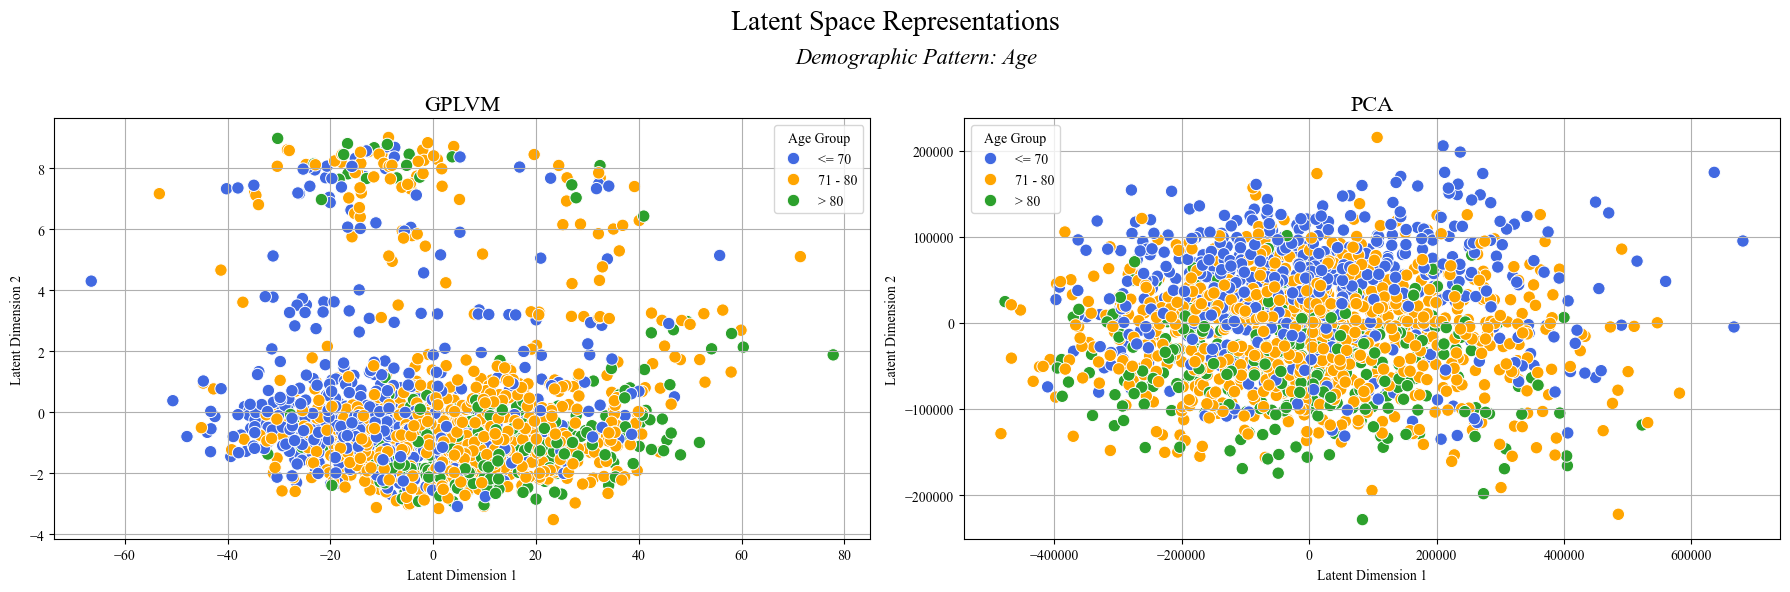

In [ ]:
# Create Age Group column for each dataframe
def assign_age_group(age):
    if age <= 70:
        return '<= 70'
    elif 71 <= age <= 80:
        return '71 - 80'
    else:
        return '> 80'

for df in [all_data_gplvm, all_data_pca]:
    df['Age Group'] = df['Age'].apply(assign_age_group)

# Define consistent color mapping for age groups
custom_palette = {
    '<= 70': 'royalblue',
    '71 - 80': 'orange',
    '> 80': '#2ca02c'  # green
}

# Plot all three with seaborn in a grid
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

datasets = [
    (all_data_gplvm, 'GPLVM'),
    (all_data_pca, 'PCA')
]

for ax, (data, title) in zip(axes, datasets):
    sns.scatterplot(
        data=data,
        x='Latent Space 1',
        y='Latent Space 2',
        hue='Age Group',
        hue_order=['<= 70', '71 - 80', '> 80'],
        palette=custom_palette,  
        s=80,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()

# Titles
fig.suptitle('Latent Space Representations', fontsize=20)
fig.text(0.445, 0.89, 'Demographic Pattern: Age', style='italic', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

### SEX Feature

In [935]:
complete = pd.read_csv('DATA/complete_data.csv')
sex = complete['PTGENDER'].dropna().astype(int)

In [936]:
all_data_gplvm = pd.read_csv('GPLVM IMPUTATION/latent_mice_df.csv')
all_data_gplvm = pd.concat([all_data_gplvm, sex], axis=1)
all_data_gplvm = all_data_gplvm.rename(columns={'Latent Dimension 1':'Latent Space 1', 'Latent Dimension 2':'Latent Space 2', 'PTGENDER':'Sex'})
all_data_gplvm = all_data_gplvm.dropna()

In [937]:
# Get latent space
all_data_pca = pd.read_csv('PCA IMPUTATION/imputed_pca_latent_mice_df.csv')
all_data_pca = pd.concat([all_data_pca, sex], axis=1)
all_data_pca = all_data_pca.rename(columns={'PC1':'Latent Space 1', 'PC2':'Latent Space 2', 'PTGENDER':'Sex'})
all_data_pca = all_data_pca.dropna()

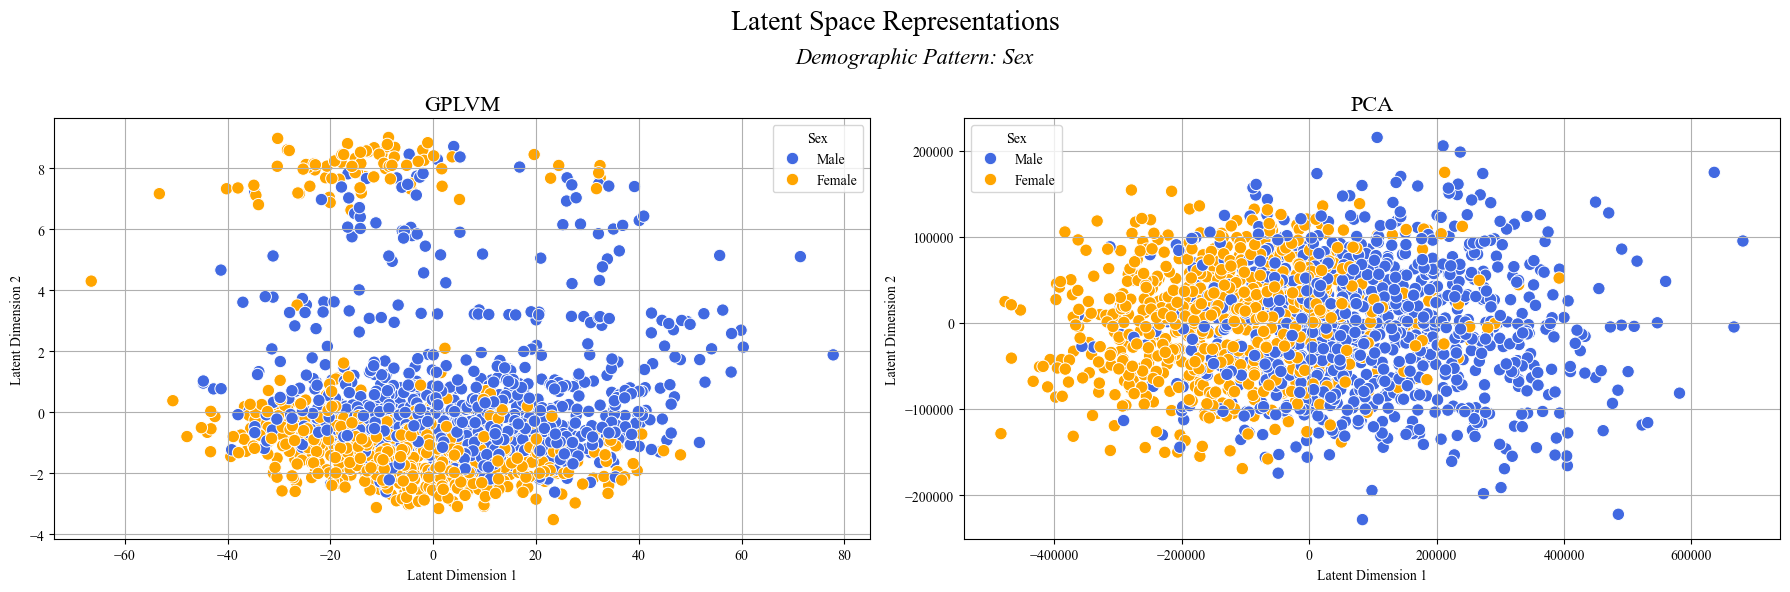

In [938]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create Age Group column for each dataframe
def assign_sex_group(sex):
    if sex == 0.0:
        return 'Male'
    else:
        return 'Female'

for df in [all_data_gplvm, all_data_pca]:
    df['Sex'] = df['Sex'].apply(assign_sex_group)

# Define consistent color mapping for age groups
custom_palette = {
    'Male': 'royalblue',
    'Female': 'orange'
}

# Plot all three with seaborn in a grid
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

datasets = [
    (all_data_gplvm, 'GPLVM'),
    (all_data_pca, 'PCA')
]

for ax, (data, title) in zip(axes, datasets):
    sns.scatterplot(
        data=data,
        x='Latent Space 1',
        y='Latent Space 2',
        hue='Sex',
        palette=custom_palette,
        s=80,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)

# Shared legend on top
handles, labels = axes[0].get_legend_handles_labels()

fig.suptitle('Latent Space Representations', fontsize=20)
fig.text(0.445, 0.89, 'Demographic Pattern: Sex', style = 'italic', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


### VENTRICULAR VOLUME Feature

In [979]:
complete = pd.read_csv('DATA/complete_data.csv')
ventricles = complete['Ventricles'].dropna().astype(int)

In [980]:
ventricles.min(), ventricles.max()

(5650, 145115)

In [981]:
all_data_gplvm = pd.read_csv('GPLVM IMPUTATION/latent_mice_df.csv')
all_data_gplvm = pd.concat([all_data_gplvm, ventricles], axis=1)
all_data_gplvm = all_data_gplvm.rename(columns={'Latent Dimension 1':'Latent Space 1', 'Latent Dimension 2':'Latent Space 2', 'Ventricles':'Ventricles'})
all_data_gplvm = all_data_gplvm.dropna()

In [982]:
# Get latent space
all_data_pca = pd.read_csv('PCA IMPUTATION/imputed_pca_latent_mice_df.csv')
all_data_pca = pd.concat([all_data_pca, ventricles], axis=1)
all_data_pca = all_data_pca.rename(columns={'PC1':'Latent Space 1', 'PC2':'Latent Space 2', 'Ventricles':'Ventricles'})
all_data_pca = all_data_pca.dropna()

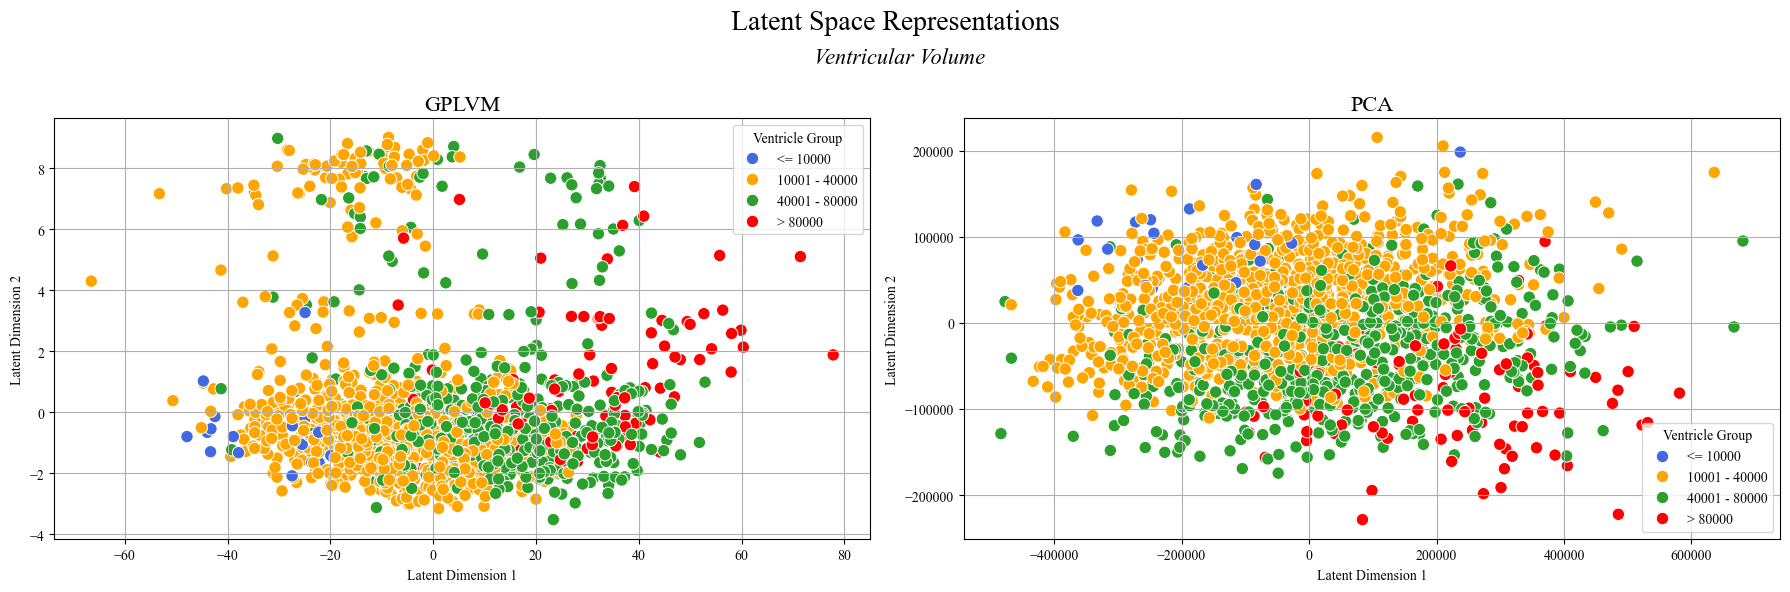

In [990]:
def assign_ventricle_group(ventricle):
    if ventricle <= 10000:
        return '<= 10000'
    elif 10000 < ventricle <= 40000:
        return '10001 - 40000'
    elif 40000 < ventricle <= 80000:
        return '40001 - 80000'
    else:
        return '> 80000'

for df in [all_data_gplvm, all_data_pca]:
    df['Ventricle Group'] = df['Ventricles'].apply(assign_ventricle_group)

# Define consistent color mapping
custom_palette = {
    '<= 10000': 'royalblue',
    '10001 - 40000': 'orange',
    '40001 - 80000': '#2ca02c',
    '> 80000': 'red'
}

# Updated hue order
hue_order = [
    '<= 10000',
    '10001 - 40000',
    '40001 - 80000',
    '> 80000'
]

# Plot with seaborn in a grid
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

datasets = [
    (all_data_gplvm, 'GPLVM'),
    (all_data_pca, 'PCA')
]

for ax, (data, title) in zip(axes, datasets):
    sns.scatterplot(
        data=data,
        x='Latent Space 1',
        y='Latent Space 2',
        hue='Ventricle Group',
        hue_order=hue_order,
        palette=custom_palette,
        s=80,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()

# Titles
fig.suptitle('Latent Space Representations', fontsize=20)
fig.text(0.455, 0.89, 'Ventricular Volume', style='italic', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
